# Wasserstein distances with outliers

In [1]:
import os
import sys
import numpy as np
import logging

import pyabc
from pyabc import ABCSMC, RedisEvalParallelSampler
from pyabc.distance import *
from pyabc.sumstat import *
from pyabc.predictor import *

if os.path.abspath(".") not in sys.path:
    sys.path.insert(0, os.abspath("."))
import slad

# for debugging
for logger in ["ABC.Distance", "ABC.Predictor", "ABC.Sumstat"]:
    logging.getLogger(logger).setLevel(logging.DEBUG)

Definitions:

In [2]:
class IdSumstat(pyabc.Sumstat):
    """Identity summary statistic."""
    def __call__(self, data: dict) -> np.ndarray:
        vals = []
        # assuming key order is always the same
        for val in data.values():
            try:
                for x in val:
                    vals.append(x)
            except TypeError:
                vals.append(val)
        # shape (n, dim)
        return np.array(vals).reshape(-1, 1)


def get_distance(name: str) -> pyabc.Distance:
    if name == "Wasserstein__2":
        return WassersteinDistance(
            p=2, sumstat=IdSumstat(),
        )
    if name == "Wasserstein__1":
        return WassersteinDistance(
            p=1, sumstat=IdSumstat(),
        )

    raise ValueError(f"Distance {name} not recognized.")


distance_names = [
    "Wasserstein__2",
    "Wasserstein__1",
]

# test
for distance_name in distance_names:
    get_distance(distance_name)
    

def save_data(data, data_dir):
    for key, val in data.items():
        if not isinstance(val, np.ndarray):
            val = np.array([val])
        np.savetxt(os.path.join(data_dir, f"data_{key}.csv"), val, delimiter=",")


def load_data(problem, data_dir):
    data = {}
    for key in problem.get_y_keys():
        data[key] = np.loadtxt(os.path.join(data_dir, f"data_{key}.csv"), delimiter=",")
        if data[key].size == 1:
            data[key] = float(data[key])
    return data


n_rep = 20

Create data:

In [5]:
for problem_type in [
    "uninf",
    "gaussian",
    #"gk",
    #"lv",
    "cr-zero",
    #"cr-swap",
]:
    for i_rep in range(n_rep):
        kwargs = {"n_obs_error": 0}

        if problem_type == "uninf":
            problem = slad.UninfErrorProblem(**kwargs)
        elif problem_type == "gaussian":
            problem = slad.GaussianErrorProblem(**kwargs)
        elif problem_type == "gk":
            problem = slad.PrangleGKErrorProblem(**kwargs)
        elif problem_type == "lv":
            problem = slad.PrangleLVErrorProblem(**kwargs)
        elif problem_type == "cr-zero":
            problem = slad.CRErrorZeroProblem(**kwargs)
        elif problem_type == "cr-swap":
            problem = slad.CRErrorSwapProblem(**kwargs)
        else:
            raise ValueError("Problem type not recognized.")

        dir = os.path.abspath(".")
        data_dir = os.path.join(dir, "..", "data_robust", f"{problem.get_id()}_{i_rep}")
        if os.path.exists(data_dir):
            data = load_data(problem, data_dir)
        else:
            os.makedirs(data_dir)
            data = problem.get_obs()
            save_data(data, data_dir)

        # errored data

        kwargs = {}
        if problem_type == "uninf":
            problem = slad.UninfErrorProblem(**kwargs)
        elif problem_type == "gaussian":
            problem = slad.GaussianErrorProblem(**kwargs)
        elif problem_type == "gk":
            problem = slad.PrangleGKErrorProblem(**kwargs)
        elif problem_type == "lv":
            problem = slad.PrangleLVErrorProblem(**kwargs)
        elif problem_type == "cr-zero":
            problem = slad.CRErrorZeroProblem(**kwargs)
        elif problem_type == "cr-swap":
            problem = slad.CRErrorSwapProblem(**kwargs)
        else:
            raise ValueError("Problem type not recognized.")

        dir = os.path.abspath(".")
        data_dir = os.path.join(dir, "..", "data_robust", f"{problem.get_id()}_{i_rep}")
        if os.path.exists(data_dir):
            continue
        os.makedirs(data_dir)

        data = problem.errorfy(data)
        save_data(data, data_dir)

Run:

In [6]:
for problem_type in [
    "uninf",
    "gaussian",
    #"gk",
    #"lv",
    "cr-zero",
    #"cr-swap",
]:
    print(problem_type)

    for i_rep in range(n_rep):
        for kwargs in [{"n_obs_error": 0}, {}]:
            if problem_type == "uninf":
                problem = slad.UninfErrorProblem(**kwargs)
                pop_size = 1000
                max_total_sim = 100000
            elif problem_type == "gaussian":
                problem = slad.GaussianErrorProblem(**kwargs)
                pop_size = 1000
                max_total_sim = 100000
            elif problem_type == "gk":
                problem = slad.PrangleGKErrorProblem(**kwargs)
                pop_size = 1000
                max_total_sim = 100000
            elif problem_type == "lv":
                problem = slad.PrangleLVErrorProblem(**kwargs)
                pop_size = 200
                max_total_sim = 50000
            elif problem_type == "cr-zero":
                problem = slad.CRErrorZeroProblem(**kwargs)
                pop_size = 1000
                max_total_sim = 100000
            elif problem_type == "cr-swap":
                problem = slad.CRErrorSwapProblem(**kwargs)
                pop_size = 1000
                max_total_sim = 100000
            else:
                raise ValueError("Problem type not recognized.")

            model = problem.get_model()
            prior = problem.get_prior()
            gt_par = problem.get_gt_par()

            # output folder
            dir = os.path.abspath(".")
            data_dir = os.path.join(
                dir, "..", "data_robust", f"{problem.get_id()}_{i_rep}"
            )

            # get data
            data = load_data(problem, data_dir)

            for distance_name in distance_names:
                print(distance_name, i_rep)

                db_file = os.path.join(data_dir, f"db_{distance_name}.db")
                if os.path.exists(db_file):
                    print(f"{db_file} exists already, continuing with next")
                    continue

                distance = get_distance(distance_name)
                if isinstance(distance, AdaptivePNormDistance):
                    distance.scale_log_file = os.path.join(
                        data_dir, f"log_scale_{distance_name}.json"
                    )
                if isinstance(distance, InfoWeightedPNormDistance):
                    distance.info_log_file = os.path.join(
                        data_dir, f"log_info_{distance_name}.json"
                    )

                #sampler = RedisEvalParallelSampler(host=host, port=port, batch_size=10)
                abc = ABCSMC(
                    model, prior, distance,
                    #sampler=sampler,
                    population_size=pop_size
                )
                abc.new(db="sqlite:///" + db_file, observed_sum_stat=data)
                abc.run(max_total_nr_simulations=max_total_sim)

print("ABC out")

ABC.Sampler INFO: Parallelize sampling on 4 processes.


uninf
Wasserstein__2 0
/home/yannik/Documents/Project7_pyABC_AdaptiveDistances/paper_robust/study_abc_rad_20210724/study_abc_rad/scripts_wasserstein/../data_robust/uninf_0_0/db_Wasserstein__2.db exists already, continuing with next
Wasserstein__1 0
/home/yannik/Documents/Project7_pyABC_AdaptiveDistances/paper_robust/study_abc_rad_20210724/study_abc_rad/scripts_wasserstein/../data_robust/uninf_0_0/db_Wasserstein__1.db exists already, continuing with next
Wasserstein__2 0
/home/yannik/Documents/Project7_pyABC_AdaptiveDistances/paper_robust/study_abc_rad_20210724/study_abc_rad/scripts_wasserstein/../data_robust/uninf_1_0/db_Wasserstein__2.db exists already, continuing with next
Wasserstein__1 0
/home/yannik/Documents/Project7_pyABC_AdaptiveDistances/paper_robust/study_abc_rad_20210724/study_abc_rad/scripts_wasserstein/../data_robust/uninf_1_0/db_Wasserstein__1.db exists already, continuing with next
Wasserstein__2 1
/home/yannik/Documents/Project7_pyABC_AdaptiveDistances/paper_robust/stud

ABC.History INFO: Start <ABCSMC id=1, start_time=2022-02-18 00:18:33>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.73734305e-01.
ABC INFO: Accepted: 1000 / 2082 = 4.8031e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.73162317e-01.
ABC INFO: Accepted: 1000 / 2088 = 4.7893e-01, ESS: 9.6717e+02.
ABC INFO: t: 2, eps: 1.67120887e-01.
ABC INFO: Accepted: 1000 / 1977 = 5.0582e-01, ESS: 9.5979e+02.
ABC INFO: t: 3, eps: 1.04375849e-01.
ABC INFO: Accepted: 1000 / 2385 = 4.1929e-01, ESS: 9.3182e+02.
ABC INFO: t: 4, eps: 8.50362364e-02.
ABC INFO: Accepted: 1000 / 3076 = 3.2510e-01, ESS: 8.7981e+02.
ABC INFO: t: 5, eps: 6.88531870e-02.
ABC INFO: Accepted: 1000 / 3092 = 3.2342e-01, ESS: 9.0161e+02.
ABC INFO: t: 6, eps: 5.63984360e-02.
ABC INFO: Accepted: 1000 / 2404 = 4.1597e-01, ESS: 9.5866e+02.
ABC INFO: t: 7, eps: 4.32945192e-02.
ABC INFO: Accepted: 1000 / 2082 = 4.8031e-01, ESS: 9.6641e+02.
ABC INFO: t: 8, eps: 3.25433938e-02.
ABC INFO: Accepted: 1000 / 2315 = 4.3197e-01, ESS: 9.256

Wasserstein__1 0


ABC INFO: t: 0, eps: 3.48888982e-01.
ABC INFO: Accepted: 1000 / 1935 = 5.1680e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.57076877e-01.
ABC INFO: Accepted: 1000 / 2012 = 4.9702e-01, ESS: 9.5458e+02.
ABC INFO: t: 2, eps: 1.54249508e-01.
ABC INFO: Accepted: 1000 / 2038 = 4.9068e-01, ESS: 9.6689e+02.
ABC INFO: t: 3, eps: 9.11207442e-02.
ABC INFO: Accepted: 1000 / 2342 = 4.2699e-01, ESS: 9.6324e+02.
ABC INFO: t: 4, eps: 6.73325431e-02.
ABC INFO: Accepted: 1000 / 3317 = 3.0148e-01, ESS: 9.3221e+02.
ABC INFO: t: 5, eps: 5.82880505e-02.
ABC INFO: Accepted: 1000 / 4002 = 2.4988e-01, ESS: 8.1253e+02.
ABC INFO: t: 6, eps: 4.86118234e-02.
ABC INFO: Accepted: 1000 / 3658 = 2.7337e-01, ESS: 9.3898e+02.
ABC INFO: t: 7, eps: 3.73841009e-02.
ABC INFO: Accepted: 1000 / 2259 = 4.4267e-01, ESS: 6.9974e+02.
ABC INFO: t: 8, eps: 2.84588997e-02.
ABC INFO: Accepted: 1000 / 2407 = 4.1545e-01, ESS: 9.6717e+02.
ABC INFO: t: 9, eps: 2.23642928e-02.
ABC INFO: Accepted: 1000 / 2402 = 4.1632e-01, ESS: 8.7666e+02.


Wasserstein__2 0


ABC INFO: t: 0, eps: 3.65622205e-01.
ABC INFO: Accepted: 1000 / 2052 = 4.8733e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.83372989e-01.
ABC INFO: Accepted: 1000 / 2123 = 4.7103e-01, ESS: 9.5592e+02.
ABC INFO: t: 2, eps: 1.84592190e-01.
ABC INFO: Accepted: 1000 / 2107 = 4.7461e-01, ESS: 9.5525e+02.
ABC INFO: t: 3, eps: 1.41310373e-01.
ABC INFO: Accepted: 1000 / 2378 = 4.2052e-01, ESS: 9.3375e+02.
ABC INFO: t: 4, eps: 1.04273191e-01.
ABC INFO: Accepted: 1000 / 2402 = 4.1632e-01, ESS: 9.6192e+02.
ABC INFO: t: 5, eps: 7.90821613e-02.
ABC INFO: Accepted: 1000 / 2046 = 4.8876e-01, ESS: 9.7553e+02.
ABC INFO: t: 6, eps: 6.78606169e-02.
ABC INFO: Accepted: 1000 / 2334 = 4.2845e-01, ESS: 9.3239e+02.
ABC INFO: t: 7, eps: 6.18244653e-02.
ABC INFO: Accepted: 1000 / 2915 = 3.4305e-01, ESS: 8.3578e+02.
ABC INFO: t: 8, eps: 5.75769632e-02.
ABC INFO: Accepted: 1000 / 3691 = 2.7093e-01, ESS: 7.0216e+02.
ABC INFO: t: 9, eps: 5.45460886e-02.
ABC INFO: Accepted: 1000 / 5131 = 1.9489e-01, ESS: 7.4579e+02.


Wasserstein__1 0


ABC INFO: t: 0, eps: 3.23763581e-01.
ABC INFO: Accepted: 1000 / 2058 = 4.8591e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.44263923e-01.
ABC INFO: Accepted: 1000 / 2140 = 4.6729e-01, ESS: 9.4674e+02.
ABC INFO: t: 2, eps: 1.53581979e-01.
ABC INFO: Accepted: 1000 / 2144 = 4.6642e-01, ESS: 9.7052e+02.
ABC INFO: t: 3, eps: 1.01768274e-01.
ABC INFO: Accepted: 1000 / 2388 = 4.1876e-01, ESS: 9.2980e+02.
ABC INFO: t: 4, eps: 8.02794125e-02.
ABC INFO: Accepted: 1000 / 3076 = 3.2510e-01, ESS: 9.0610e+02.
ABC INFO: t: 5, eps: 6.24245816e-02.
ABC INFO: Accepted: 1000 / 2393 = 4.1789e-01, ESS: 9.6198e+02.
ABC INFO: t: 6, eps: 5.33714461e-02.
ABC INFO: Accepted: 1000 / 2732 = 3.6603e-01, ESS: 9.2111e+02.
ABC INFO: t: 7, eps: 4.79329653e-02.
ABC INFO: Accepted: 1000 / 3208 = 3.1172e-01, ESS: 8.3308e+02.
ABC INFO: t: 8, eps: 4.34187065e-02.
ABC INFO: Accepted: 1000 / 3396 = 2.9446e-01, ESS: 7.6238e+02.
ABC INFO: t: 9, eps: 3.98140844e-02.
ABC INFO: Accepted: 1000 / 4663 = 2.1445e-01, ESS: 7.1207e+02.


Wasserstein__2 1


ABC INFO: t: 0, eps: 3.68929530e-01.
ABC INFO: Accepted: 1000 / 1927 = 5.1894e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.75755950e-01.
ABC INFO: Accepted: 1000 / 2060 = 4.8544e-01, ESS: 9.4242e+02.
ABC INFO: t: 2, eps: 1.62911057e-01.
ABC INFO: Accepted: 1000 / 2085 = 4.7962e-01, ESS: 9.7630e+02.
ABC INFO: t: 3, eps: 1.04836515e-01.
ABC INFO: Accepted: 1000 / 2258 = 4.4287e-01, ESS: 8.8103e+02.
ABC INFO: t: 4, eps: 8.60019315e-02.
ABC INFO: Accepted: 1000 / 2816 = 3.5511e-01, ESS: 8.9219e+02.
ABC INFO: t: 5, eps: 6.61541451e-02.
ABC INFO: Accepted: 1000 / 3072 = 3.2552e-01, ESS: 9.3781e+02.
ABC INFO: t: 6, eps: 5.44453274e-02.
ABC INFO: Accepted: 1000 / 2604 = 3.8402e-01, ESS: 9.3411e+02.
ABC INFO: t: 7, eps: 4.38952157e-02.
ABC INFO: Accepted: 1000 / 2266 = 4.4131e-01, ESS: 9.5861e+02.
ABC INFO: t: 8, eps: 3.41821588e-02.
ABC INFO: Accepted: 1000 / 2218 = 4.5086e-01, ESS: 9.6489e+02.
ABC INFO: t: 9, eps: 2.75055077e-02.
ABC INFO: Accepted: 1000 / 2382 = 4.1982e-01, ESS: 9.4661e+02.


Wasserstein__1 1


ABC INFO: t: 0, eps: 3.38887770e-01.
ABC INFO: Accepted: 1000 / 2018 = 4.9554e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.58669002e-01.
ABC INFO: Accepted: 1000 / 2013 = 4.9677e-01, ESS: 9.6257e+02.
ABC INFO: t: 2, eps: 1.50734113e-01.
ABC INFO: Accepted: 1000 / 2171 = 4.6062e-01, ESS: 9.5238e+02.
ABC INFO: t: 3, eps: 8.67260648e-02.
ABC INFO: Accepted: 1000 / 2373 = 4.2141e-01, ESS: 8.8428e+02.
ABC INFO: t: 4, eps: 6.53983074e-02.
ABC INFO: Accepted: 1000 / 3421 = 2.9231e-01, ESS: 9.1300e+02.
ABC INFO: t: 5, eps: 5.38442513e-02.
ABC INFO: Accepted: 1000 / 3730 = 2.6810e-01, ESS: 9.5228e+02.
ABC INFO: t: 6, eps: 4.35038110e-02.
ABC INFO: Accepted: 1000 / 2587 = 3.8655e-01, ESS: 9.2620e+02.
ABC INFO: t: 7, eps: 3.35672164e-02.
ABC INFO: Accepted: 1000 / 2297 = 4.3535e-01, ESS: 9.5594e+02.
ABC INFO: t: 8, eps: 2.54034259e-02.
ABC INFO: Accepted: 1000 / 2446 = 4.0883e-01, ESS: 9.3018e+02.
ABC INFO: t: 9, eps: 2.01382955e-02.
ABC INFO: Accepted: 1000 / 2774 = 3.6049e-01, ESS: 7.1587e+02.


Wasserstein__2 1


ABC INFO: t: 0, eps: 3.65881807e-01.
ABC INFO: Accepted: 1000 / 1916 = 5.2192e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.78748122e-01.
ABC INFO: Accepted: 1000 / 2172 = 4.6041e-01, ESS: 9.4894e+02.
ABC INFO: t: 2, eps: 1.68894388e-01.
ABC INFO: Accepted: 1000 / 2171 = 4.6062e-01, ESS: 9.7038e+02.
ABC INFO: t: 3, eps: 1.29708498e-01.
ABC INFO: Accepted: 1000 / 2526 = 3.9588e-01, ESS: 9.2175e+02.
ABC INFO: t: 4, eps: 9.32243552e-02.
ABC INFO: Accepted: 1000 / 2525 = 3.9604e-01, ESS: 9.5103e+02.
ABC INFO: t: 5, eps: 7.31404602e-02.
ABC INFO: Accepted: 1000 / 2105 = 4.7506e-01, ESS: 9.6854e+02.
ABC INFO: t: 6, eps: 6.39600824e-02.
ABC INFO: Accepted: 1000 / 2472 = 4.0453e-01, ESS: 9.3257e+02.
ABC INFO: t: 7, eps: 5.77043206e-02.
ABC INFO: Accepted: 1000 / 2914 = 3.4317e-01, ESS: 8.4213e+02.
ABC INFO: t: 8, eps: 5.30520073e-02.
ABC INFO: Accepted: 1000 / 3791 = 2.6378e-01, ESS: 5.9978e+02.
ABC INFO: t: 9, eps: 4.94761952e-02.
ABC INFO: Accepted: 1000 / 5103 = 1.9596e-01, ESS: 7.6026e+02.


Wasserstein__1 1


ABC INFO: t: 0, eps: 3.24201071e-01.
ABC INFO: Accepted: 1000 / 1940 = 5.1546e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.52996916e-01.
ABC INFO: Accepted: 1000 / 2135 = 4.6838e-01, ESS: 9.5153e+02.
ABC INFO: t: 2, eps: 1.60269578e-01.
ABC INFO: Accepted: 1000 / 2153 = 4.6447e-01, ESS: 9.5092e+02.
ABC INFO: t: 3, eps: 1.00931356e-01.
ABC INFO: Accepted: 1000 / 2374 = 4.2123e-01, ESS: 9.3884e+02.
ABC INFO: t: 4, eps: 7.94563216e-02.
ABC INFO: Accepted: 1000 / 3074 = 3.2531e-01, ESS: 9.3614e+02.
ABC INFO: t: 5, eps: 6.15491150e-02.
ABC INFO: Accepted: 1000 / 3039 = 3.2906e-01, ESS: 9.7403e+02.
ABC INFO: t: 6, eps: 5.26230053e-02.
ABC INFO: Accepted: 1000 / 2700 = 3.7037e-01, ESS: 9.2536e+02.
ABC INFO: t: 7, eps: 4.49053602e-02.
ABC INFO: Accepted: 1000 / 2697 = 3.7078e-01, ESS: 8.9190e+02.
ABC INFO: t: 8, eps: 3.81756496e-02.
ABC INFO: Accepted: 1000 / 2581 = 3.8745e-01, ESS: 8.8209e+02.
ABC INFO: t: 9, eps: 3.35673138e-02.
ABC INFO: Accepted: 1000 / 2821 = 3.5448e-01, ESS: 8.2991e+02.


Wasserstein__2 2


ABC INFO: t: 0, eps: 3.76118013e-01.
ABC INFO: Accepted: 1000 / 2100 = 4.7619e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.74860201e-01.
ABC INFO: Accepted: 1000 / 2038 = 4.9068e-01, ESS: 9.4638e+02.
ABC INFO: t: 2, eps: 1.61484700e-01.
ABC INFO: Accepted: 1000 / 2074 = 4.8216e-01, ESS: 9.8590e+02.
ABC INFO: t: 3, eps: 1.06760506e-01.
ABC INFO: Accepted: 1000 / 2316 = 4.3178e-01, ESS: 9.4996e+02.
ABC INFO: t: 4, eps: 8.58325130e-02.
ABC INFO: Accepted: 1000 / 3118 = 3.2072e-01, ESS: 9.0872e+02.
ABC INFO: t: 5, eps: 7.29254359e-02.
ABC INFO: Accepted: 1000 / 2992 = 3.3422e-01, ESS: 9.3751e+02.
ABC INFO: t: 6, eps: 5.79144140e-02.
ABC INFO: Accepted: 1000 / 2284 = 4.3783e-01, ESS: 9.7631e+02.
ABC INFO: t: 7, eps: 4.40150031e-02.
ABC INFO: Accepted: 1000 / 2124 = 4.7081e-01, ESS: 9.7626e+02.
ABC INFO: t: 8, eps: 3.41993685e-02.
ABC INFO: Accepted: 1000 / 2197 = 4.5517e-01, ESS: 9.5151e+02.
ABC INFO: t: 9, eps: 2.76405889e-02.
ABC INFO: Accepted: 1000 / 2507 = 3.9888e-01, ESS: 9.0358e+02.


Wasserstein__1 2


ABC INFO: t: 0, eps: 3.47652814e-01.
ABC INFO: Accepted: 1000 / 2084 = 4.7985e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.44372424e-01.
ABC INFO: Accepted: 1000 / 2028 = 4.9310e-01, ESS: 9.7630e+02.
ABC INFO: t: 2, eps: 1.38194941e-01.
ABC INFO: Accepted: 1000 / 2185 = 4.5767e-01, ESS: 9.3938e+02.
ABC INFO: t: 3, eps: 8.35871853e-02.
ABC INFO: Accepted: 1000 / 2457 = 4.0700e-01, ESS: 9.2790e+02.
ABC INFO: t: 4, eps: 6.29018673e-02.
ABC INFO: Accepted: 1000 / 3511 = 2.8482e-01, ESS: 9.2487e+02.
ABC INFO: t: 5, eps: 5.43466673e-02.
ABC INFO: Accepted: 1000 / 3618 = 2.7640e-01, ESS: 8.1990e+02.
ABC INFO: t: 6, eps: 4.48157956e-02.
ABC INFO: Accepted: 1000 / 3287 = 3.0423e-01, ESS: 9.2513e+02.
ABC INFO: t: 7, eps: 3.48049570e-02.
ABC INFO: Accepted: 1000 / 2333 = 4.2863e-01, ESS: 9.5530e+02.
ABC INFO: t: 8, eps: 2.73233258e-02.
ABC INFO: Accepted: 1000 / 2287 = 4.3725e-01, ESS: 9.4907e+02.
ABC INFO: t: 9, eps: 2.15703327e-02.
ABC INFO: Accepted: 1000 / 2431 = 4.1135e-01, ESS: 9.1321e+02.


Wasserstein__2 2


ABC INFO: t: 0, eps: 3.52191619e-01.
ABC INFO: Accepted: 1000 / 2026 = 4.9358e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.71655810e-01.
ABC INFO: Accepted: 1000 / 2083 = 4.8008e-01, ESS: 9.6087e+02.
ABC INFO: t: 2, eps: 1.76739215e-01.
ABC INFO: Accepted: 1000 / 2167 = 4.6147e-01, ESS: 9.7430e+02.
ABC INFO: t: 3, eps: 1.35257920e-01.
ABC INFO: Accepted: 1000 / 2532 = 3.9494e-01, ESS: 9.3961e+02.
ABC INFO: t: 4, eps: 9.18845351e-02.
ABC INFO: Accepted: 1000 / 2134 = 4.6860e-01, ESS: 9.4873e+02.
ABC INFO: t: 5, eps: 6.71411676e-02.
ABC INFO: Accepted: 1000 / 2037 = 4.9092e-01, ESS: 9.7756e+02.
ABC INFO: t: 6, eps: 5.68009955e-02.
ABC INFO: Accepted: 1000 / 2272 = 4.4014e-01, ESS: 9.5732e+02.
ABC INFO: t: 7, eps: 5.08970465e-02.
ABC INFO: Accepted: 1000 / 3145 = 3.1797e-01, ESS: 8.8596e+02.
ABC INFO: t: 8, eps: 4.72385211e-02.
ABC INFO: Accepted: 1000 / 4736 = 2.1115e-01, ESS: 8.1479e+02.
ABC INFO: t: 9, eps: 4.42010389e-02.
ABC INFO: Accepted: 1000 / 9193 = 1.0878e-01, ESS: 8.1575e+02.


Wasserstein__1 2


ABC INFO: t: 0, eps: 3.07989754e-01.
ABC INFO: Accepted: 1000 / 2052 = 4.8733e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.37917896e-01.
ABC INFO: Accepted: 1000 / 2167 = 4.6147e-01, ESS: 9.3394e+02.
ABC INFO: t: 2, eps: 1.45282392e-01.
ABC INFO: Accepted: 1000 / 2280 = 4.3860e-01, ESS: 9.6334e+02.
ABC INFO: t: 3, eps: 1.02315566e-01.
ABC INFO: Accepted: 1000 / 2528 = 3.9557e-01, ESS: 9.1462e+02.
ABC INFO: t: 4, eps: 8.08929110e-02.
ABC INFO: Accepted: 1000 / 2934 = 3.4083e-01, ESS: 9.1148e+02.
ABC INFO: t: 5, eps: 5.58560605e-02.
ABC INFO: Accepted: 1000 / 2164 = 4.6211e-01, ESS: 9.6742e+02.
ABC INFO: t: 6, eps: 4.59181244e-02.
ABC INFO: Accepted: 1000 / 2403 = 4.1615e-01, ESS: 9.6425e+02.
ABC INFO: t: 7, eps: 4.01647465e-02.
ABC INFO: Accepted: 1000 / 3279 = 3.0497e-01, ESS: 8.4405e+02.
ABC INFO: t: 8, eps: 3.63518775e-02.
ABC INFO: Accepted: 1000 / 5028 = 1.9889e-01, ESS: 8.1854e+02.
ABC INFO: t: 9, eps: 3.33128627e-02.
ABC INFO: Accepted: 1000 / 7125 = 1.4035e-01, ESS: 6.3120e+02.


Wasserstein__2 3


ABC INFO: t: 0, eps: 3.63348091e-01.
ABC INFO: Accepted: 1000 / 2049 = 4.8804e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.67901342e-01.
ABC INFO: Accepted: 1000 / 1977 = 5.0582e-01, ESS: 9.6427e+02.
ABC INFO: t: 2, eps: 1.64175096e-01.
ABC INFO: Accepted: 1000 / 2063 = 4.8473e-01, ESS: 9.5099e+02.
ABC INFO: t: 3, eps: 1.05216440e-01.
ABC INFO: Accepted: 1000 / 2368 = 4.2230e-01, ESS: 9.3129e+02.
ABC INFO: t: 4, eps: 8.56515439e-02.
ABC INFO: Accepted: 1000 / 2834 = 3.5286e-01, ESS: 8.5318e+02.
ABC INFO: t: 5, eps: 6.68921473e-02.
ABC INFO: Accepted: 1000 / 3136 = 3.1888e-01, ESS: 9.1234e+02.
ABC INFO: t: 6, eps: 5.46912337e-02.
ABC INFO: Accepted: 1000 / 2710 = 3.6900e-01, ESS: 9.5105e+02.
ABC INFO: t: 7, eps: 4.35627305e-02.
ABC INFO: Accepted: 1000 / 2295 = 4.3573e-01, ESS: 9.5629e+02.
ABC INFO: t: 8, eps: 3.40974238e-02.
ABC INFO: Accepted: 1000 / 2360 = 4.2373e-01, ESS: 9.6714e+02.
ABC INFO: t: 9, eps: 2.76412045e-02.
ABC INFO: Accepted: 1000 / 2482 = 4.0290e-01, ESS: 8.5925e+02.


Wasserstein__1 3


ABC INFO: t: 0, eps: 3.39439410e-01.
ABC INFO: Accepted: 1000 / 2032 = 4.9213e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.47122440e-01.
ABC INFO: Accepted: 1000 / 2012 = 4.9702e-01, ESS: 9.4339e+02.
ABC INFO: t: 2, eps: 1.45547868e-01.
ABC INFO: Accepted: 1000 / 2073 = 4.8239e-01, ESS: 9.5936e+02.
ABC INFO: t: 3, eps: 8.81772272e-02.
ABC INFO: Accepted: 1000 / 2337 = 4.2790e-01, ESS: 9.0417e+02.
ABC INFO: t: 4, eps: 6.50171313e-02.
ABC INFO: Accepted: 1000 / 3471 = 2.8810e-01, ESS: 9.4485e+02.
ABC INFO: t: 5, eps: 5.57939984e-02.
ABC INFO: Accepted: 1000 / 3995 = 2.5031e-01, ESS: 8.2815e+02.
ABC INFO: t: 6, eps: 4.60633372e-02.
ABC INFO: Accepted: 1000 / 3028 = 3.3025e-01, ESS: 9.5137e+02.
ABC INFO: t: 7, eps: 3.60249941e-02.
ABC INFO: Accepted: 1000 / 2255 = 4.4346e-01, ESS: 9.5681e+02.
ABC INFO: t: 8, eps: 2.81507433e-02.
ABC INFO: Accepted: 1000 / 2272 = 4.4014e-01, ESS: 9.2424e+02.
ABC INFO: t: 9, eps: 2.24548212e-02.
ABC INFO: Accepted: 1000 / 2492 = 4.0128e-01, ESS: 8.8236e+02.


Wasserstein__2 3


ABC INFO: t: 0, eps: 3.67143980e-01.
ABC INFO: Accepted: 1000 / 1945 = 5.1414e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.69981884e-01.
ABC INFO: Accepted: 1000 / 1987 = 5.0327e-01, ESS: 9.4036e+02.
ABC INFO: t: 2, eps: 1.59075769e-01.
ABC INFO: Accepted: 1000 / 2096 = 4.7710e-01, ESS: 9.7586e+02.
ABC INFO: t: 3, eps: 1.03403191e-01.
ABC INFO: Accepted: 1000 / 2302 = 4.3440e-01, ESS: 9.2588e+02.
ABC INFO: t: 4, eps: 8.28685296e-02.
ABC INFO: Accepted: 1000 / 3045 = 3.2841e-01, ESS: 8.7941e+02.
ABC INFO: t: 5, eps: 6.60443389e-02.
ABC INFO: Accepted: 1000 / 2816 = 3.5511e-01, ESS: 9.5148e+02.
ABC INFO: t: 6, eps: 5.31823040e-02.
ABC INFO: Accepted: 1000 / 2574 = 3.8850e-01, ESS: 9.4926e+02.
ABC INFO: t: 7, eps: 4.17750100e-02.
ABC INFO: Accepted: 1000 / 2320 = 4.3103e-01, ESS: 9.7804e+02.
ABC INFO: t: 8, eps: 3.23040622e-02.
ABC INFO: Accepted: 1000 / 2197 = 4.5517e-01, ESS: 9.5649e+02.
ABC INFO: t: 9, eps: 2.58796494e-02.
ABC INFO: Accepted: 1000 / 2467 = 4.0535e-01, ESS: 8.9967e+02.


Wasserstein__1 3


ABC INFO: t: 0, eps: 3.41368868e-01.
ABC INFO: Accepted: 1000 / 1949 = 5.1308e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.44937760e-01.
ABC INFO: Accepted: 1000 / 2083 = 4.8008e-01, ESS: 9.4936e+02.
ABC INFO: t: 2, eps: 1.45778029e-01.
ABC INFO: Accepted: 1000 / 2009 = 4.9776e-01, ESS: 9.4745e+02.
ABC INFO: t: 3, eps: 8.85367040e-02.
ABC INFO: Accepted: 1000 / 2233 = 4.4783e-01, ESS: 9.0218e+02.
ABC INFO: t: 4, eps: 6.39936155e-02.
ABC INFO: Accepted: 1000 / 3524 = 2.8377e-01, ESS: 9.3299e+02.
ABC INFO: t: 5, eps: 5.40660006e-02.
ABC INFO: Accepted: 1000 / 3958 = 2.5265e-01, ESS: 9.0074e+02.
ABC INFO: t: 6, eps: 4.35012166e-02.
ABC INFO: Accepted: 1000 / 2868 = 3.4868e-01, ESS: 9.3857e+02.
ABC INFO: t: 7, eps: 3.34871408e-02.
ABC INFO: Accepted: 1000 / 2423 = 4.1271e-01, ESS: 9.7214e+02.
ABC INFO: t: 8, eps: 2.57395918e-02.
ABC INFO: Accepted: 1000 / 2379 = 4.2034e-01, ESS: 9.4346e+02.
ABC INFO: t: 9, eps: 2.07492324e-02.
ABC INFO: Accepted: 1000 / 2536 = 3.9432e-01, ESS: 9.0068e+02.


Wasserstein__2 4


ABC INFO: t: 0, eps: 3.71194589e-01.
ABC INFO: Accepted: 1000 / 2011 = 4.9727e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.82778259e-01.
ABC INFO: Accepted: 1000 / 2143 = 4.6664e-01, ESS: 9.7360e+02.
ABC INFO: t: 2, eps: 1.69878526e-01.
ABC INFO: Accepted: 1000 / 2026 = 4.9358e-01, ESS: 9.5529e+02.
ABC INFO: t: 3, eps: 1.07761564e-01.
ABC INFO: Accepted: 1000 / 2304 = 4.3403e-01, ESS: 9.5326e+02.
ABC INFO: t: 4, eps: 8.50447712e-02.
ABC INFO: Accepted: 1000 / 3171 = 3.1536e-01, ESS: 9.1401e+02.
ABC INFO: t: 5, eps: 6.87968818e-02.
ABC INFO: Accepted: 1000 / 2982 = 3.3535e-01, ESS: 9.4029e+02.
ABC INFO: t: 6, eps: 5.62796881e-02.
ABC INFO: Accepted: 1000 / 2610 = 3.8314e-01, ESS: 9.5139e+02.
ABC INFO: t: 7, eps: 4.36265549e-02.
ABC INFO: Accepted: 1000 / 2202 = 4.5413e-01, ESS: 9.7176e+02.
ABC INFO: t: 8, eps: 3.49164785e-02.
ABC INFO: Accepted: 1000 / 2175 = 4.5977e-01, ESS: 9.6257e+02.
ABC INFO: t: 9, eps: 2.79362297e-02.
ABC INFO: Accepted: 1000 / 2400 = 4.1667e-01, ESS: 8.9518e+02.


Wasserstein__1 4


ABC INFO: t: 0, eps: 3.36039138e-01.
ABC INFO: Accepted: 1000 / 2279 = 4.3879e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.41669072e-01.
ABC INFO: Accepted: 1000 / 2031 = 4.9237e-01, ESS: 9.5434e+02.
ABC INFO: t: 2, eps: 1.42222721e-01.
ABC INFO: Accepted: 1000 / 2021 = 4.9480e-01, ESS: 9.5210e+02.
ABC INFO: t: 3, eps: 8.78481577e-02.
ABC INFO: Accepted: 1000 / 2409 = 4.1511e-01, ESS: 9.3654e+02.
ABC INFO: t: 4, eps: 6.50916242e-02.
ABC INFO: Accepted: 1000 / 3418 = 2.9257e-01, ESS: 8.9373e+02.
ABC INFO: t: 5, eps: 5.62280268e-02.
ABC INFO: Accepted: 1000 / 3844 = 2.6015e-01, ESS: 8.5565e+02.
ABC INFO: t: 6, eps: 4.57503817e-02.
ABC INFO: Accepted: 1000 / 2877 = 3.4758e-01, ESS: 9.4494e+02.
ABC INFO: t: 7, eps: 3.59595427e-02.
ABC INFO: Accepted: 1000 / 2170 = 4.6083e-01, ESS: 9.5634e+02.
ABC INFO: t: 8, eps: 2.76925636e-02.
ABC INFO: Accepted: 1000 / 2401 = 4.1649e-01, ESS: 9.4305e+02.
ABC INFO: t: 9, eps: 2.23632358e-02.
ABC INFO: Accepted: 1000 / 2499 = 4.0016e-01, ESS: 8.7615e+02.


Wasserstein__2 4


ABC INFO: t: 0, eps: 3.40273992e-01.
ABC INFO: Accepted: 1000 / 1981 = 5.0480e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.72618645e-01.
ABC INFO: Accepted: 1000 / 2028 = 4.9310e-01, ESS: 9.3423e+02.
ABC INFO: t: 2, eps: 1.78167046e-01.
ABC INFO: Accepted: 1000 / 2012 = 4.9702e-01, ESS: 9.4765e+02.
ABC INFO: t: 3, eps: 1.33530022e-01.
ABC INFO: Accepted: 1000 / 2376 = 4.2088e-01, ESS: 9.2143e+02.
ABC INFO: t: 4, eps: 9.38601711e-02.
ABC INFO: Accepted: 1000 / 2444 = 4.0917e-01, ESS: 9.6467e+02.
ABC INFO: t: 5, eps: 6.62501381e-02.
ABC INFO: Accepted: 1000 / 2096 = 4.7710e-01, ESS: 9.8606e+02.
ABC INFO: t: 6, eps: 5.29192112e-02.
ABC INFO: Accepted: 1000 / 2196 = 4.5537e-01, ESS: 9.6685e+02.
ABC INFO: t: 7, eps: 4.71693802e-02.
ABC INFO: Accepted: 1000 / 2813 = 3.5549e-01, ESS: 8.9334e+02.
ABC INFO: t: 8, eps: 4.35070564e-02.
ABC INFO: Accepted: 1000 / 4091 = 2.4444e-01, ESS: 8.1035e+02.
ABC INFO: t: 9, eps: 4.07625735e-02.
ABC INFO: Accepted: 1000 / 6502 = 1.5380e-01, ESS: 7.1966e+02.


Wasserstein__1 4


ABC INFO: t: 0, eps: 2.96315618e-01.
ABC INFO: Accepted: 1000 / 2044 = 4.8924e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.32626115e-01.
ABC INFO: Accepted: 1000 / 2056 = 4.8638e-01, ESS: 9.5633e+02.
ABC INFO: t: 2, eps: 1.41482361e-01.
ABC INFO: Accepted: 1000 / 2303 = 4.3422e-01, ESS: 9.4686e+02.
ABC INFO: t: 3, eps: 1.01101432e-01.
ABC INFO: Accepted: 1000 / 2637 = 3.7922e-01, ESS: 9.3794e+02.
ABC INFO: t: 4, eps: 7.45481663e-02.
ABC INFO: Accepted: 1000 / 2963 = 3.3750e-01, ESS: 9.4707e+02.
ABC INFO: t: 5, eps: 5.12159672e-02.
ABC INFO: Accepted: 1000 / 2085 = 4.7962e-01, ESS: 9.6861e+02.
ABC INFO: t: 6, eps: 4.11857628e-02.
ABC INFO: Accepted: 1000 / 2387 = 4.1894e-01, ESS: 9.3107e+02.
ABC INFO: t: 7, eps: 3.61446011e-02.
ABC INFO: Accepted: 1000 / 3245 = 3.0817e-01, ESS: 8.7161e+02.
ABC INFO: t: 8, eps: 3.28059228e-02.
ABC INFO: Accepted: 1000 / 4998 = 2.0008e-01, ESS: 8.1623e+02.
ABC INFO: t: 9, eps: 3.04556388e-02.
ABC INFO: Accepted: 1000 / 7148 = 1.3990e-01, ESS: 5.5633e+02.


Wasserstein__2 5


ABC INFO: t: 0, eps: 3.64208292e-01.
ABC INFO: Accepted: 1000 / 2069 = 4.8333e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.78442371e-01.
ABC INFO: Accepted: 1000 / 2024 = 4.9407e-01, ESS: 9.5305e+02.
ABC INFO: t: 2, eps: 1.76198248e-01.
ABC INFO: Accepted: 1000 / 1983 = 5.0429e-01, ESS: 9.4995e+02.
ABC INFO: t: 3, eps: 1.10383546e-01.
ABC INFO: Accepted: 1000 / 2280 = 4.3860e-01, ESS: 9.5999e+02.
ABC INFO: t: 4, eps: 8.75980349e-02.
ABC INFO: Accepted: 1000 / 3140 = 3.1847e-01, ESS: 9.1186e+02.
ABC INFO: t: 5, eps: 7.10337506e-02.
ABC INFO: Accepted: 1000 / 2780 = 3.5971e-01, ESS: 9.2540e+02.
ABC INFO: t: 6, eps: 5.78216829e-02.
ABC INFO: Accepted: 1000 / 2662 = 3.7566e-01, ESS: 9.5371e+02.
ABC INFO: t: 7, eps: 4.50238871e-02.
ABC INFO: Accepted: 1000 / 2220 = 4.5045e-01, ESS: 9.8279e+02.
ABC INFO: t: 8, eps: 3.59984924e-02.
ABC INFO: Accepted: 1000 / 2306 = 4.3365e-01, ESS: 9.5429e+02.
ABC INFO: t: 9, eps: 3.04043911e-02.
ABC INFO: Accepted: 1000 / 2331 = 4.2900e-01, ESS: 8.9628e+02.


Wasserstein__1 5


ABC INFO: t: 0, eps: 3.34457862e-01.
ABC INFO: Accepted: 1000 / 2041 = 4.8996e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.40710794e-01.
ABC INFO: Accepted: 1000 / 2058 = 4.8591e-01, ESS: 9.5548e+02.
ABC INFO: t: 2, eps: 1.42358560e-01.
ABC INFO: Accepted: 1000 / 2079 = 4.8100e-01, ESS: 9.7346e+02.
ABC INFO: t: 3, eps: 8.44955370e-02.
ABC INFO: Accepted: 1000 / 2498 = 4.0032e-01, ESS: 9.3878e+02.
ABC INFO: t: 4, eps: 6.27625705e-02.
ABC INFO: Accepted: 1000 / 3416 = 2.9274e-01, ESS: 9.1670e+02.
ABC INFO: t: 5, eps: 5.42329426e-02.
ABC INFO: Accepted: 1000 / 3955 = 2.5284e-01, ESS: 8.3777e+02.
ABC INFO: t: 6, eps: 4.53512179e-02.
ABC INFO: Accepted: 1000 / 3025 = 3.3058e-01, ESS: 9.5457e+02.
ABC INFO: t: 7, eps: 3.50989669e-02.
ABC INFO: Accepted: 1000 / 2245 = 4.4543e-01, ESS: 9.0706e+02.
ABC INFO: t: 8, eps: 2.82780827e-02.
ABC INFO: Accepted: 1000 / 2283 = 4.3802e-01, ESS: 9.0794e+02.
ABC INFO: t: 9, eps: 2.33781578e-02.
ABC INFO: Accepted: 1000 / 2513 = 3.9793e-01, ESS: 8.4580e+02.


Wasserstein__2 5


ABC INFO: t: 0, eps: 3.43854014e-01.
ABC INFO: Accepted: 1000 / 1937 = 5.1626e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.81115676e-01.
ABC INFO: Accepted: 1000 / 1911 = 5.2329e-01, ESS: 9.6065e+02.
ABC INFO: t: 2, eps: 1.90464253e-01.
ABC INFO: Accepted: 1000 / 2095 = 4.7733e-01, ESS: 9.2921e+02.
ABC INFO: t: 3, eps: 1.43381243e-01.
ABC INFO: Accepted: 1000 / 2240 = 4.4643e-01, ESS: 9.2028e+02.
ABC INFO: t: 4, eps: 1.06075709e-01.
ABC INFO: Accepted: 1000 / 2478 = 4.0355e-01, ESS: 9.6440e+02.
ABC INFO: t: 5, eps: 7.25689232e-02.
ABC INFO: Accepted: 1000 / 2228 = 4.4883e-01, ESS: 9.8899e+02.
ABC INFO: t: 6, eps: 5.79342026e-02.
ABC INFO: Accepted: 1000 / 2263 = 4.4189e-01, ESS: 9.4878e+02.
ABC INFO: t: 7, eps: 5.18892055e-02.
ABC INFO: Accepted: 1000 / 2743 = 3.6456e-01, ESS: 9.1992e+02.
ABC INFO: t: 8, eps: 4.78075481e-02.
ABC INFO: Accepted: 1000 / 4358 = 2.2946e-01, ESS: 7.0321e+02.
ABC INFO: t: 9, eps: 4.50194393e-02.
ABC INFO: Accepted: 1000 / 7088 = 1.4108e-01, ESS: 8.2999e+02.


Wasserstein__1 5


ABC INFO: t: 0, eps: 2.95710481e-01.
ABC INFO: Accepted: 1000 / 2074 = 4.8216e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.32041050e-01.
ABC INFO: Accepted: 1000 / 2078 = 4.8123e-01, ESS: 9.4653e+02.
ABC INFO: t: 2, eps: 1.48264212e-01.
ABC INFO: Accepted: 1000 / 2041 = 4.8996e-01, ESS: 9.1916e+02.
ABC INFO: t: 3, eps: 1.04904245e-01.
ABC INFO: Accepted: 1000 / 2513 = 3.9793e-01, ESS: 9.2976e+02.
ABC INFO: t: 4, eps: 8.25185917e-02.
ABC INFO: Accepted: 1000 / 3030 = 3.3003e-01, ESS: 8.5544e+02.
ABC INFO: t: 5, eps: 5.71049716e-02.
ABC INFO: Accepted: 1000 / 2092 = 4.7801e-01, ESS: 9.6104e+02.
ABC INFO: t: 6, eps: 4.60171117e-02.
ABC INFO: Accepted: 1000 / 2292 = 4.3630e-01, ESS: 9.4843e+02.
ABC INFO: t: 7, eps: 4.07817038e-02.
ABC INFO: Accepted: 1000 / 3379 = 2.9595e-01, ESS: 8.2119e+02.
ABC INFO: t: 8, eps: 3.73537920e-02.
ABC INFO: Accepted: 1000 / 4870 = 2.0534e-01, ESS: 8.0724e+02.
ABC INFO: t: 9, eps: 3.45492266e-02.
ABC INFO: Accepted: 1000 / 7020 = 1.4245e-01, ESS: 6.6911e+02.


Wasserstein__2 6


ABC INFO: t: 0, eps: 3.67591824e-01.
ABC INFO: Accepted: 1000 / 2074 = 4.8216e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.82026791e-01.
ABC INFO: Accepted: 1000 / 2018 = 4.9554e-01, ESS: 9.2803e+02.
ABC INFO: t: 2, eps: 1.64845371e-01.
ABC INFO: Accepted: 1000 / 2149 = 4.6533e-01, ESS: 9.6030e+02.
ABC INFO: t: 3, eps: 1.06651419e-01.
ABC INFO: Accepted: 1000 / 2377 = 4.2070e-01, ESS: 9.2552e+02.
ABC INFO: t: 4, eps: 8.47376938e-02.
ABC INFO: Accepted: 1000 / 3146 = 3.1786e-01, ESS: 8.9393e+02.
ABC INFO: t: 5, eps: 6.37578054e-02.
ABC INFO: Accepted: 1000 / 2500 = 4.0000e-01, ESS: 9.6348e+02.
ABC INFO: t: 6, eps: 5.25206560e-02.
ABC INFO: Accepted: 1000 / 2493 = 4.0112e-01, ESS: 9.5420e+02.
ABC INFO: t: 7, eps: 4.18615702e-02.
ABC INFO: Accepted: 1000 / 2533 = 3.9479e-01, ESS: 9.7477e+02.
ABC INFO: t: 8, eps: 3.37885280e-02.
ABC INFO: Accepted: 1000 / 2261 = 4.4228e-01, ESS: 9.2983e+02.
ABC INFO: t: 9, eps: 2.82650245e-02.
ABC INFO: Accepted: 1000 / 2728 = 3.6657e-01, ESS: 8.0718e+02.


Wasserstein__1 6


ABC INFO: t: 0, eps: 3.41585741e-01.
ABC INFO: Accepted: 1000 / 1992 = 5.0201e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.53890034e-01.
ABC INFO: Accepted: 1000 / 2080 = 4.8077e-01, ESS: 9.5379e+02.
ABC INFO: t: 2, eps: 1.52240450e-01.
ABC INFO: Accepted: 1000 / 2036 = 4.9116e-01, ESS: 9.7318e+02.
ABC INFO: t: 3, eps: 8.82945415e-02.
ABC INFO: Accepted: 1000 / 2456 = 4.0717e-01, ESS: 9.5027e+02.
ABC INFO: t: 4, eps: 6.88279831e-02.
ABC INFO: Accepted: 1000 / 3361 = 2.9753e-01, ESS: 9.2232e+02.
ABC INFO: t: 5, eps: 5.33925309e-02.
ABC INFO: Accepted: 1000 / 3169 = 3.1556e-01, ESS: 9.4503e+02.
ABC INFO: t: 6, eps: 4.30049362e-02.
ABC INFO: Accepted: 1000 / 2889 = 3.4614e-01, ESS: 9.4307e+02.
ABC INFO: t: 7, eps: 3.42524017e-02.
ABC INFO: Accepted: 1000 / 2566 = 3.8971e-01, ESS: 9.2118e+02.
ABC INFO: t: 8, eps: 2.81061077e-02.
ABC INFO: Accepted: 1000 / 2383 = 4.1964e-01, ESS: 8.9272e+02.
ABC INFO: t: 9, eps: 2.31167167e-02.
ABC INFO: Accepted: 1000 / 2860 = 3.4965e-01, ESS: 8.2506e+02.


Wasserstein__2 6


ABC INFO: t: 0, eps: 3.60722525e-01.
ABC INFO: Accepted: 1000 / 1993 = 5.0176e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.82285015e-01.
ABC INFO: Accepted: 1000 / 2034 = 4.9164e-01, ESS: 9.5034e+02.
ABC INFO: t: 2, eps: 1.86575007e-01.
ABC INFO: Accepted: 1000 / 2053 = 4.8709e-01, ESS: 9.3018e+02.
ABC INFO: t: 3, eps: 1.44491756e-01.
ABC INFO: Accepted: 1000 / 2368 = 4.2230e-01, ESS: 9.2443e+02.
ABC INFO: t: 4, eps: 1.04371158e-01.
ABC INFO: Accepted: 1000 / 2418 = 4.1356e-01, ESS: 9.5827e+02.
ABC INFO: t: 5, eps: 7.52498162e-02.
ABC INFO: Accepted: 1000 / 2117 = 4.7237e-01, ESS: 9.7568e+02.
ABC INFO: t: 6, eps: 6.20145908e-02.
ABC INFO: Accepted: 1000 / 2238 = 4.4683e-01, ESS: 9.5199e+02.
ABC INFO: t: 7, eps: 5.58575921e-02.
ABC INFO: Accepted: 1000 / 2998 = 3.3356e-01, ESS: 9.1229e+02.
ABC INFO: t: 8, eps: 5.23713293e-02.
ABC INFO: Accepted: 1000 / 4361 = 2.2931e-01, ESS: 8.4062e+02.
ABC INFO: t: 9, eps: 4.93420458e-02.
ABC INFO: Accepted: 1000 / 7162 = 1.3963e-01, ESS: 6.7731e+02.


Wasserstein__1 6


ABC INFO: t: 0, eps: 3.16276719e-01.
ABC INFO: Accepted: 1000 / 1996 = 5.0100e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.50190563e-01.
ABC INFO: Accepted: 1000 / 2038 = 4.9068e-01, ESS: 9.5822e+02.
ABC INFO: t: 2, eps: 1.63058090e-01.
ABC INFO: Accepted: 1000 / 2145 = 4.6620e-01, ESS: 9.5984e+02.
ABC INFO: t: 3, eps: 1.10012152e-01.
ABC INFO: Accepted: 1000 / 2547 = 3.9262e-01, ESS: 9.4196e+02.
ABC INFO: t: 4, eps: 8.59993403e-02.
ABC INFO: Accepted: 1000 / 3161 = 3.1636e-01, ESS: 9.1164e+02.
ABC INFO: t: 5, eps: 5.94277097e-02.
ABC INFO: Accepted: 1000 / 2194 = 4.5579e-01, ESS: 9.5139e+02.
ABC INFO: t: 6, eps: 4.99254938e-02.
ABC INFO: Accepted: 1000 / 2396 = 4.1736e-01, ESS: 9.3381e+02.
ABC INFO: t: 7, eps: 4.47951591e-02.
ABC INFO: Accepted: 1000 / 3394 = 2.9464e-01, ESS: 8.6221e+02.
ABC INFO: t: 8, eps: 4.12692362e-02.
ABC INFO: Accepted: 1000 / 4500 = 2.2222e-01, ESS: 7.6249e+02.
ABC INFO: t: 9, eps: 3.85179372e-02.
ABC INFO: Accepted: 1000 / 5845 = 1.7109e-01, ESS: 5.8866e+02.


Wasserstein__2 7


ABC INFO: t: 0, eps: 3.72769804e-01.
ABC INFO: Accepted: 1000 / 1899 = 5.2659e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.89213882e-01.
ABC INFO: Accepted: 1000 / 2006 = 4.9850e-01, ESS: 9.5604e+02.
ABC INFO: t: 2, eps: 1.85995664e-01.
ABC INFO: Accepted: 1000 / 1979 = 5.0531e-01, ESS: 9.0928e+02.
ABC INFO: t: 3, eps: 1.14714396e-01.
ABC INFO: Accepted: 1000 / 2177 = 4.5935e-01, ESS: 9.1594e+02.
ABC INFO: t: 4, eps: 8.63792659e-02.
ABC INFO: Accepted: 1000 / 2959 = 3.3795e-01, ESS: 9.1487e+02.
ABC INFO: t: 5, eps: 7.12739790e-02.
ABC INFO: Accepted: 1000 / 3350 = 2.9851e-01, ESS: 9.3646e+02.
ABC INFO: t: 6, eps: 5.85220388e-02.
ABC INFO: Accepted: 1000 / 2504 = 3.9936e-01, ESS: 9.4005e+02.
ABC INFO: t: 7, eps: 4.62272207e-02.
ABC INFO: Accepted: 1000 / 2545 = 3.9293e-01, ESS: 9.8013e+02.
ABC INFO: t: 8, eps: 3.61905487e-02.
ABC INFO: Accepted: 1000 / 2218 = 4.5086e-01, ESS: 9.7078e+02.
ABC INFO: t: 9, eps: 2.89495672e-02.
ABC INFO: Accepted: 1000 / 2327 = 4.2974e-01, ESS: 9.0101e+02.


Wasserstein__1 7


ABC INFO: t: 0, eps: 3.41587336e-01.
ABC INFO: Accepted: 1000 / 1977 = 5.0582e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.58604843e-01.
ABC INFO: Accepted: 1000 / 1989 = 5.0277e-01, ESS: 9.7193e+02.
ABC INFO: t: 2, eps: 1.51685120e-01.
ABC INFO: Accepted: 1000 / 2090 = 4.7847e-01, ESS: 9.4955e+02.
ABC INFO: t: 3, eps: 9.03882631e-02.
ABC INFO: Accepted: 1000 / 2419 = 4.1339e-01, ESS: 9.5366e+02.
ABC INFO: t: 4, eps: 6.51568696e-02.
ABC INFO: Accepted: 1000 / 3172 = 3.1526e-01, ESS: 9.1843e+02.
ABC INFO: t: 5, eps: 5.66508293e-02.
ABC INFO: Accepted: 1000 / 3962 = 2.5240e-01, ESS: 8.6453e+02.
ABC INFO: t: 6, eps: 4.64669276e-02.
ABC INFO: Accepted: 1000 / 3119 = 3.2062e-01, ESS: 9.4021e+02.
ABC INFO: t: 7, eps: 3.64394453e-02.
ABC INFO: Accepted: 1000 / 2288 = 4.3706e-01, ESS: 9.7294e+02.
ABC INFO: t: 8, eps: 2.80065769e-02.
ABC INFO: Accepted: 1000 / 2359 = 4.2391e-01, ESS: 9.5300e+02.
ABC INFO: t: 9, eps: 2.22257981e-02.
ABC INFO: Accepted: 1000 / 2542 = 3.9339e-01, ESS: 8.9223e+02.


Wasserstein__2 7


ABC INFO: t: 0, eps: 3.44110770e-01.
ABC INFO: Accepted: 1000 / 2012 = 4.9702e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.65572808e-01.
ABC INFO: Accepted: 1000 / 2100 = 4.7619e-01, ESS: 9.5677e+02.
ABC INFO: t: 2, eps: 1.73867683e-01.
ABC INFO: Accepted: 1000 / 2058 = 4.8591e-01, ESS: 9.4221e+02.
ABC INFO: t: 3, eps: 1.31807974e-01.
ABC INFO: Accepted: 1000 / 2442 = 4.0950e-01, ESS: 8.9714e+02.
ABC INFO: t: 4, eps: 8.71789267e-02.
ABC INFO: Accepted: 1000 / 2141 = 4.6707e-01, ESS: 9.6611e+02.
ABC INFO: t: 5, eps: 5.96352390e-02.
ABC INFO: Accepted: 1000 / 2105 = 4.7506e-01, ESS: 9.7243e+02.
ABC INFO: t: 6, eps: 4.86171991e-02.
ABC INFO: Accepted: 1000 / 2298 = 4.3516e-01, ESS: 9.4285e+02.
ABC INFO: t: 7, eps: 4.34282074e-02.
ABC INFO: Accepted: 1000 / 3159 = 3.1656e-01, ESS: 9.2276e+02.
ABC INFO: t: 8, eps: 3.98769844e-02.
ABC INFO: Accepted: 1000 / 5098 = 1.9616e-01, ESS: 8.8398e+02.
ABC INFO: t: 9, eps: 3.69531444e-02.
ABC INFO: Accepted: 1000 / 8208 = 1.2183e-01, ESS: 8.3909e+02.


Wasserstein__1 7


ABC INFO: t: 0, eps: 3.00415914e-01.
ABC INFO: Accepted: 1000 / 2008 = 4.9801e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.33982650e-01.
ABC INFO: Accepted: 1000 / 2131 = 4.6926e-01, ESS: 9.5706e+02.
ABC INFO: t: 2, eps: 1.48962985e-01.
ABC INFO: Accepted: 1000 / 2153 = 4.6447e-01, ESS: 9.3163e+02.
ABC INFO: t: 3, eps: 1.05999986e-01.
ABC INFO: Accepted: 1000 / 2352 = 4.2517e-01, ESS: 8.7803e+02.
ABC INFO: t: 4, eps: 8.64078223e-02.
ABC INFO: Accepted: 1000 / 2900 = 3.4483e-01, ESS: 9.4299e+02.
ABC INFO: t: 5, eps: 5.79533099e-02.
ABC INFO: Accepted: 1000 / 2089 = 4.7870e-01, ESS: 9.7868e+02.
ABC INFO: t: 6, eps: 4.15376762e-02.
ABC INFO: Accepted: 1000 / 2125 = 4.7059e-01, ESS: 9.5589e+02.
ABC INFO: t: 7, eps: 3.52260952e-02.
ABC INFO: Accepted: 1000 / 2566 = 3.8971e-01, ESS: 8.9461e+02.
ABC INFO: t: 8, eps: 3.13501857e-02.
ABC INFO: Accepted: 1000 / 3725 = 2.6846e-01, ESS: 8.1709e+02.
ABC INFO: t: 9, eps: 2.86575007e-02.
ABC INFO: Accepted: 1000 / 5498 = 1.8188e-01, ESS: 7.5012e+02.


Wasserstein__2 8


ABC INFO: t: 0, eps: 3.60544449e-01.
ABC INFO: Accepted: 1000 / 1982 = 5.0454e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.73938118e-01.
ABC INFO: Accepted: 1000 / 2149 = 4.6533e-01, ESS: 9.6633e+02.
ABC INFO: t: 2, eps: 1.57201116e-01.
ABC INFO: Accepted: 1000 / 2209 = 4.5269e-01, ESS: 9.5629e+02.
ABC INFO: t: 3, eps: 9.70478602e-02.
ABC INFO: Accepted: 1000 / 2427 = 4.1203e-01, ESS: 9.5396e+02.
ABC INFO: t: 4, eps: 7.87132737e-02.
ABC INFO: Accepted: 1000 / 3217 = 3.1085e-01, ESS: 8.4834e+02.
ABC INFO: t: 5, eps: 6.74832195e-02.
ABC INFO: Accepted: 1000 / 3411 = 2.9317e-01, ESS: 8.7974e+02.
ABC INFO: t: 6, eps: 5.46391486e-02.
ABC INFO: Accepted: 1000 / 2410 = 4.1494e-01, ESS: 9.6519e+02.
ABC INFO: t: 7, eps: 4.29684543e-02.
ABC INFO: Accepted: 1000 / 2142 = 4.6685e-01, ESS: 9.6133e+02.
ABC INFO: t: 8, eps: 3.37259631e-02.
ABC INFO: Accepted: 1000 / 2253 = 4.4385e-01, ESS: 9.4955e+02.
ABC INFO: t: 9, eps: 2.73772416e-02.
ABC INFO: Accepted: 1000 / 2442 = 4.0950e-01, ESS: 9.0371e+02.


Wasserstein__1 8


ABC INFO: t: 0, eps: 3.36110386e-01.
ABC INFO: Accepted: 1000 / 2089 = 4.7870e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.46815436e-01.
ABC INFO: Accepted: 1000 / 2065 = 4.8426e-01, ESS: 9.5777e+02.
ABC INFO: t: 2, eps: 1.37673171e-01.
ABC INFO: Accepted: 1000 / 2114 = 4.7304e-01, ESS: 9.4587e+02.
ABC INFO: t: 3, eps: 8.29633209e-02.
ABC INFO: Accepted: 1000 / 2301 = 4.3459e-01, ESS: 9.0937e+02.
ABC INFO: t: 4, eps: 6.27640978e-02.
ABC INFO: Accepted: 1000 / 3522 = 2.8393e-01, ESS: 9.1553e+02.
ABC INFO: t: 5, eps: 5.48156763e-02.
ABC INFO: Accepted: 1000 / 4021 = 2.4869e-01, ESS: 8.6114e+02.
ABC INFO: t: 6, eps: 4.61260873e-02.
ABC INFO: Accepted: 1000 / 3474 = 2.8785e-01, ESS: 8.3785e+02.
ABC INFO: t: 7, eps: 3.57696659e-02.
ABC INFO: Accepted: 1000 / 2400 = 4.1667e-01, ESS: 9.6538e+02.
ABC INFO: t: 8, eps: 2.79571842e-02.
ABC INFO: Accepted: 1000 / 2256 = 4.4326e-01, ESS: 9.4016e+02.
ABC INFO: t: 9, eps: 2.22796145e-02.
ABC INFO: Accepted: 1000 / 2517 = 3.9730e-01, ESS: 9.2678e+02.


Wasserstein__2 8


ABC INFO: t: 0, eps: 3.48231983e-01.
ABC INFO: Accepted: 1000 / 1960 = 5.1020e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.69468854e-01.
ABC INFO: Accepted: 1000 / 2072 = 4.8263e-01, ESS: 9.6606e+02.
ABC INFO: t: 2, eps: 1.78625388e-01.
ABC INFO: Accepted: 1000 / 2102 = 4.7574e-01, ESS: 9.5977e+02.
ABC INFO: t: 3, eps: 1.32761766e-01.
ABC INFO: Accepted: 1000 / 2357 = 4.2427e-01, ESS: 9.2877e+02.
ABC INFO: t: 4, eps: 9.53178050e-02.
ABC INFO: Accepted: 1000 / 2648 = 3.7764e-01, ESS: 9.2893e+02.
ABC INFO: t: 5, eps: 7.16746540e-02.
ABC INFO: Accepted: 1000 / 2070 = 4.8309e-01, ESS: 9.7217e+02.
ABC INFO: t: 6, eps: 6.07563195e-02.
ABC INFO: Accepted: 1000 / 2220 = 4.5045e-01, ESS: 9.4738e+02.
ABC INFO: t: 7, eps: 5.45237249e-02.
ABC INFO: Accepted: 1000 / 3056 = 3.2723e-01, ESS: 9.1002e+02.
ABC INFO: t: 8, eps: 5.03673689e-02.
ABC INFO: Accepted: 1000 / 4103 = 2.4372e-01, ESS: 5.5655e+02.
ABC INFO: t: 9, eps: 4.69603518e-02.
ABC INFO: Accepted: 1000 / 6146 = 1.6271e-01, ESS: 6.0031e+02.


Wasserstein__1 8


ABC INFO: t: 0, eps: 3.07295837e-01.
ABC INFO: Accepted: 1000 / 2034 = 4.9164e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.41872340e-01.
ABC INFO: Accepted: 1000 / 2181 = 4.5851e-01, ESS: 9.3697e+02.
ABC INFO: t: 2, eps: 1.51361097e-01.
ABC INFO: Accepted: 1000 / 2084 = 4.7985e-01, ESS: 9.5660e+02.
ABC INFO: t: 3, eps: 9.95639085e-02.
ABC INFO: Accepted: 1000 / 2589 = 3.8625e-01, ESS: 9.2328e+02.
ABC INFO: t: 4, eps: 7.45977142e-02.
ABC INFO: Accepted: 1000 / 3197 = 3.1279e-01, ESS: 9.3981e+02.
ABC INFO: t: 5, eps: 5.45985975e-02.
ABC INFO: Accepted: 1000 / 2198 = 4.5496e-01, ESS: 9.5294e+02.
ABC INFO: t: 6, eps: 4.67192254e-02.
ABC INFO: Accepted: 1000 / 2570 = 3.8911e-01, ESS: 9.1110e+02.
ABC INFO: t: 7, eps: 4.19237241e-02.
ABC INFO: Accepted: 1000 / 3292 = 3.0377e-01, ESS: 8.4917e+02.
ABC INFO: t: 8, eps: 3.83409598e-02.
ABC INFO: Accepted: 1000 / 4419 = 2.2630e-01, ESS: 7.4490e+02.
ABC INFO: t: 9, eps: 3.54064444e-02.
ABC INFO: Accepted: 1000 / 5874 = 1.7024e-01, ESS: 6.3697e+02.


Wasserstein__2 9


ABC INFO: t: 0, eps: 3.72559451e-01.
ABC INFO: Accepted: 1000 / 1964 = 5.0916e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.78758894e-01.
ABC INFO: Accepted: 1000 / 1974 = 5.0659e-01, ESS: 9.5722e+02.
ABC INFO: t: 2, eps: 1.65279013e-01.
ABC INFO: Accepted: 1000 / 2069 = 4.8333e-01, ESS: 9.3416e+02.
ABC INFO: t: 3, eps: 1.05609462e-01.
ABC INFO: Accepted: 1000 / 2273 = 4.3995e-01, ESS: 9.3538e+02.
ABC INFO: t: 4, eps: 8.40113788e-02.
ABC INFO: Accepted: 1000 / 3147 = 3.1776e-01, ESS: 8.8552e+02.
ABC INFO: t: 5, eps: 7.23757935e-02.
ABC INFO: Accepted: 1000 / 3284 = 3.0451e-01, ESS: 8.3888e+02.
ABC INFO: t: 6, eps: 5.65242566e-02.
ABC INFO: Accepted: 1000 / 2422 = 4.1288e-01, ESS: 9.4889e+02.
ABC INFO: t: 7, eps: 4.26431696e-02.
ABC INFO: Accepted: 1000 / 2335 = 4.2827e-01, ESS: 9.8446e+02.
ABC INFO: t: 8, eps: 3.23775945e-02.
ABC INFO: Accepted: 1000 / 2276 = 4.3937e-01, ESS: 9.4408e+02.
ABC INFO: t: 9, eps: 2.64416883e-02.
ABC INFO: Accepted: 1000 / 2475 = 4.0404e-01, ESS: 9.0795e+02.


Wasserstein__1 9


ABC INFO: t: 0, eps: 3.46608703e-01.
ABC INFO: Accepted: 1000 / 2001 = 4.9975e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.55356425e-01.
ABC INFO: Accepted: 1000 / 2036 = 4.9116e-01, ESS: 9.5556e+02.
ABC INFO: t: 2, eps: 1.58015448e-01.
ABC INFO: Accepted: 1000 / 1911 = 5.2329e-01, ESS: 9.2976e+02.
ABC INFO: t: 3, eps: 9.61335526e-02.
ABC INFO: Accepted: 1000 / 2169 = 4.6104e-01, ESS: 9.3206e+02.
ABC INFO: t: 4, eps: 6.72406701e-02.
ABC INFO: Accepted: 1000 / 2904 = 3.4435e-01, ESS: 8.9867e+02.
ABC INFO: t: 5, eps: 5.66838917e-02.
ABC INFO: Accepted: 1000 / 3954 = 2.5291e-01, ESS: 9.3202e+02.
ABC INFO: t: 6, eps: 4.87522208e-02.
ABC INFO: Accepted: 1000 / 3207 = 3.1182e-01, ESS: 9.0842e+02.
ABC INFO: t: 7, eps: 3.83010351e-02.
ABC INFO: Accepted: 1000 / 2645 = 3.7807e-01, ESS: 9.6573e+02.
ABC INFO: t: 8, eps: 2.92827387e-02.
ABC INFO: Accepted: 1000 / 2240 = 4.4643e-01, ESS: 9.6559e+02.
ABC INFO: t: 9, eps: 2.29602011e-02.
ABC INFO: Accepted: 1000 / 2429 = 4.1169e-01, ESS: 9.3059e+02.


Wasserstein__2 9


ABC INFO: t: 0, eps: 3.55373577e-01.
ABC INFO: Accepted: 1000 / 1966 = 5.0865e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.80678317e-01.
ABC INFO: Accepted: 1000 / 1992 = 5.0201e-01, ESS: 9.4192e+02.
ABC INFO: t: 2, eps: 1.85037265e-01.
ABC INFO: Accepted: 1000 / 2002 = 4.9950e-01, ESS: 9.6478e+02.
ABC INFO: t: 3, eps: 1.36460490e-01.
ABC INFO: Accepted: 1000 / 2516 = 3.9746e-01, ESS: 9.3754e+02.
ABC INFO: t: 4, eps: 9.62639967e-02.
ABC INFO: Accepted: 1000 / 2639 = 3.7893e-01, ESS: 9.3353e+02.
ABC INFO: t: 5, eps: 7.07206750e-02.
ABC INFO: Accepted: 1000 / 2231 = 4.4823e-01, ESS: 9.8443e+02.
ABC INFO: t: 6, eps: 6.07698501e-02.
ABC INFO: Accepted: 1000 / 2483 = 4.0274e-01, ESS: 8.5377e+02.
ABC INFO: t: 7, eps: 5.50962188e-02.
ABC INFO: Accepted: 1000 / 3180 = 3.1447e-01, ESS: 8.1282e+02.
ABC INFO: t: 8, eps: 5.10587191e-02.
ABC INFO: Accepted: 1000 / 4346 = 2.3010e-01, ESS: 7.1001e+02.
ABC INFO: t: 9, eps: 4.76750451e-02.
ABC INFO: Accepted: 1000 / 7326 = 1.3650e-01, ESS: 6.2110e+02.


Wasserstein__1 9


ABC INFO: t: 0, eps: 3.14662538e-01.
ABC INFO: Accepted: 1000 / 1937 = 5.1626e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.49692714e-01.
ABC INFO: Accepted: 1000 / 2107 = 4.7461e-01, ESS: 9.5872e+02.
ABC INFO: t: 2, eps: 1.54619884e-01.
ABC INFO: Accepted: 1000 / 2183 = 4.5809e-01, ESS: 9.5480e+02.
ABC INFO: t: 3, eps: 1.05077718e-01.
ABC INFO: Accepted: 1000 / 2459 = 4.0667e-01, ESS: 9.3564e+02.
ABC INFO: t: 4, eps: 8.13624035e-02.
ABC INFO: Accepted: 1000 / 3101 = 3.2248e-01, ESS: 9.5295e+02.
ABC INFO: t: 5, eps: 5.92838203e-02.
ABC INFO: Accepted: 1000 / 2195 = 4.5558e-01, ESS: 9.6899e+02.
ABC INFO: t: 6, eps: 5.01554143e-02.
ABC INFO: Accepted: 1000 / 2431 = 4.1135e-01, ESS: 8.9912e+02.
ABC INFO: t: 7, eps: 4.48271120e-02.
ABC INFO: Accepted: 1000 / 3153 = 3.1716e-01, ESS: 8.9386e+02.
ABC INFO: t: 8, eps: 4.10746978e-02.
ABC INFO: Accepted: 1000 / 4090 = 2.4450e-01, ESS: 7.7835e+02.
ABC INFO: t: 9, eps: 3.80552401e-02.
ABC INFO: Accepted: 1000 / 5826 = 1.7164e-01, ESS: 7.3300e+02.


Wasserstein__2 10


ABC INFO: t: 0, eps: 3.75011297e-01.
ABC INFO: Accepted: 1000 / 2076 = 4.8170e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.71624479e-01.
ABC INFO: Accepted: 1000 / 2084 = 4.7985e-01, ESS: 9.7224e+02.
ABC INFO: t: 2, eps: 1.56995733e-01.
ABC INFO: Accepted: 1000 / 2097 = 4.7687e-01, ESS: 9.4277e+02.
ABC INFO: t: 3, eps: 9.83056787e-02.
ABC INFO: Accepted: 1000 / 2524 = 3.9620e-01, ESS: 9.2891e+02.
ABC INFO: t: 4, eps: 7.92564638e-02.
ABC INFO: Accepted: 1000 / 3237 = 3.0893e-01, ESS: 8.9061e+02.
ABC INFO: t: 5, eps: 6.39641817e-02.
ABC INFO: Accepted: 1000 / 2958 = 3.3807e-01, ESS: 8.8766e+02.
ABC INFO: t: 6, eps: 5.02451269e-02.
ABC INFO: Accepted: 1000 / 2419 = 4.1339e-01, ESS: 9.6910e+02.
ABC INFO: t: 7, eps: 3.92753480e-02.
ABC INFO: Accepted: 1000 / 2198 = 4.5496e-01, ESS: 9.7426e+02.
ABC INFO: t: 8, eps: 3.09656977e-02.
ABC INFO: Accepted: 1000 / 2258 = 4.4287e-01, ESS: 9.4590e+02.
ABC INFO: t: 9, eps: 2.54445651e-02.
ABC INFO: Accepted: 1000 / 2527 = 3.9573e-01, ESS: 8.5077e+02.


Wasserstein__1 10


ABC INFO: t: 0, eps: 3.49880076e-01.
ABC INFO: Accepted: 1000 / 1962 = 5.0968e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.56176512e-01.
ABC INFO: Accepted: 1000 / 1915 = 5.2219e-01, ESS: 9.2406e+02.
ABC INFO: t: 2, eps: 1.47756600e-01.
ABC INFO: Accepted: 1000 / 2122 = 4.7125e-01, ESS: 9.4774e+02.
ABC INFO: t: 3, eps: 8.64617244e-02.
ABC INFO: Accepted: 1000 / 2315 = 4.3197e-01, ESS: 9.5672e+02.
ABC INFO: t: 4, eps: 6.30894217e-02.
ABC INFO: Accepted: 1000 / 3322 = 3.0102e-01, ESS: 9.1618e+02.
ABC INFO: t: 5, eps: 5.47911058e-02.
ABC INFO: Accepted: 1000 / 4006 = 2.4963e-01, ESS: 8.4531e+02.
ABC INFO: t: 6, eps: 4.48764636e-02.
ABC INFO: Accepted: 1000 / 3042 = 3.2873e-01, ESS: 8.8474e+02.
ABC INFO: t: 7, eps: 3.44908783e-02.
ABC INFO: Accepted: 1000 / 2326 = 4.2992e-01, ESS: 8.5048e+02.
ABC INFO: t: 8, eps: 2.74690244e-02.
ABC INFO: Accepted: 1000 / 2298 = 4.3516e-01, ESS: 9.4400e+02.
ABC INFO: t: 9, eps: 2.14640710e-02.
ABC INFO: Accepted: 1000 / 2657 = 3.7636e-01, ESS: 8.5835e+02.


Wasserstein__2 10


ABC INFO: t: 0, eps: 3.51747487e-01.
ABC INFO: Accepted: 1000 / 1995 = 5.0125e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.68586000e-01.
ABC INFO: Accepted: 1000 / 2018 = 4.9554e-01, ESS: 9.4138e+02.
ABC INFO: t: 2, eps: 1.78220497e-01.
ABC INFO: Accepted: 1000 / 2175 = 4.5977e-01, ESS: 9.5256e+02.
ABC INFO: t: 3, eps: 1.35611628e-01.
ABC INFO: Accepted: 1000 / 2459 = 4.0667e-01, ESS: 9.2690e+02.
ABC INFO: t: 4, eps: 8.87399163e-02.
ABC INFO: Accepted: 1000 / 2378 = 4.2052e-01, ESS: 9.2350e+02.
ABC INFO: t: 5, eps: 6.18920214e-02.
ABC INFO: Accepted: 1000 / 2072 = 4.8263e-01, ESS: 9.7755e+02.
ABC INFO: t: 6, eps: 5.12920541e-02.
ABC INFO: Accepted: 1000 / 2220 = 4.5045e-01, ESS: 9.6024e+02.
ABC INFO: t: 7, eps: 4.55310370e-02.
ABC INFO: Accepted: 1000 / 2909 = 3.4376e-01, ESS: 7.5273e+02.
ABC INFO: t: 8, eps: 4.19788934e-02.
ABC INFO: Accepted: 1000 / 4905 = 2.0387e-01, ESS: 8.2866e+02.
ABC INFO: t: 9, eps: 3.90390201e-02.
ABC INFO: Accepted: 1000 / 7895 = 1.2666e-01, ESS: 7.7931e+02.


Wasserstein__1 10


ABC INFO: t: 0, eps: 3.09827319e-01.
ABC INFO: Accepted: 1000 / 2091 = 4.7824e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.42303003e-01.
ABC INFO: Accepted: 1000 / 2059 = 4.8567e-01, ESS: 9.7924e+02.
ABC INFO: t: 2, eps: 1.53316463e-01.
ABC INFO: Accepted: 1000 / 2083 = 4.8008e-01, ESS: 8.8771e+02.
ABC INFO: t: 3, eps: 1.04955040e-01.
ABC INFO: Accepted: 1000 / 2644 = 3.7821e-01, ESS: 9.3708e+02.
ABC INFO: t: 4, eps: 8.08318814e-02.
ABC INFO: Accepted: 1000 / 3109 = 3.2165e-01, ESS: 8.6154e+02.
ABC INFO: t: 5, eps: 5.43177558e-02.
ABC INFO: Accepted: 1000 / 2102 = 4.7574e-01, ESS: 9.6342e+02.
ABC INFO: t: 6, eps: 4.22572629e-02.
ABC INFO: Accepted: 1000 / 2118 = 4.7214e-01, ESS: 9.6507e+02.
ABC INFO: t: 7, eps: 3.61523724e-02.
ABC INFO: Accepted: 1000 / 2804 = 3.5663e-01, ESS: 9.1543e+02.
ABC INFO: t: 8, eps: 3.22694928e-02.
ABC INFO: Accepted: 1000 / 4021 = 2.4869e-01, ESS: 8.4285e+02.
ABC INFO: t: 9, eps: 2.95559497e-02.
ABC INFO: Accepted: 1000 / 5612 = 1.7819e-01, ESS: 6.8625e+02.


Wasserstein__2 11


ABC INFO: t: 0, eps: 3.68196832e-01.
ABC INFO: Accepted: 1000 / 2061 = 4.8520e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.81918442e-01.
ABC INFO: Accepted: 1000 / 2090 = 4.7847e-01, ESS: 9.6404e+02.
ABC INFO: t: 2, eps: 1.63935089e-01.
ABC INFO: Accepted: 1000 / 2129 = 4.6970e-01, ESS: 9.5873e+02.
ABC INFO: t: 3, eps: 1.04690252e-01.
ABC INFO: Accepted: 1000 / 2227 = 4.4903e-01, ESS: 9.4336e+02.
ABC INFO: t: 4, eps: 8.25888635e-02.
ABC INFO: Accepted: 1000 / 3006 = 3.3267e-01, ESS: 9.0046e+02.
ABC INFO: t: 5, eps: 7.26082392e-02.
ABC INFO: Accepted: 1000 / 3407 = 2.9351e-01, ESS: 8.7629e+02.
ABC INFO: t: 6, eps: 5.92620346e-02.
ABC INFO: Accepted: 1000 / 2489 = 4.0177e-01, ESS: 9.6921e+02.
ABC INFO: t: 7, eps: 4.47297778e-02.
ABC INFO: Accepted: 1000 / 2191 = 4.5641e-01, ESS: 9.8039e+02.
ABC INFO: t: 8, eps: 3.51938752e-02.
ABC INFO: Accepted: 1000 / 2094 = 4.7755e-01, ESS: 9.2413e+02.
ABC INFO: t: 9, eps: 2.79351803e-02.
ABC INFO: Accepted: 1000 / 2391 = 4.1824e-01, ESS: 9.2873e+02.


Wasserstein__1 11


ABC INFO: t: 0, eps: 3.49083842e-01.
ABC INFO: Accepted: 1000 / 1838 = 5.4407e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.71526238e-01.
ABC INFO: Accepted: 1000 / 1998 = 5.0050e-01, ESS: 9.5334e+02.
ABC INFO: t: 2, eps: 1.61134803e-01.
ABC INFO: Accepted: 1000 / 2022 = 4.9456e-01, ESS: 9.6084e+02.
ABC INFO: t: 3, eps: 9.35505423e-02.
ABC INFO: Accepted: 1000 / 2206 = 4.5331e-01, ESS: 9.5335e+02.
ABC INFO: t: 4, eps: 6.66248393e-02.
ABC INFO: Accepted: 1000 / 2998 = 3.3356e-01, ESS: 9.3604e+02.
ABC INFO: t: 5, eps: 5.41924445e-02.
ABC INFO: Accepted: 1000 / 3662 = 2.7307e-01, ESS: 9.4182e+02.
ABC INFO: t: 6, eps: 4.61806164e-02.
ABC INFO: Accepted: 1000 / 3152 = 3.1726e-01, ESS: 8.5189e+02.
ABC INFO: t: 7, eps: 3.68352412e-02.
ABC INFO: Accepted: 1000 / 2567 = 3.8956e-01, ESS: 9.6472e+02.
ABC INFO: t: 8, eps: 2.80569250e-02.
ABC INFO: Accepted: 1000 / 2219 = 4.5065e-01, ESS: 9.5979e+02.
ABC INFO: t: 9, eps: 2.19937407e-02.
ABC INFO: Accepted: 1000 / 2451 = 4.0800e-01, ESS: 8.9685e+02.


Wasserstein__2 11


ABC INFO: t: 0, eps: 3.68949548e-01.
ABC INFO: Accepted: 1000 / 2040 = 4.9020e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.76789384e-01.
ABC INFO: Accepted: 1000 / 2045 = 4.8900e-01, ESS: 9.3243e+02.
ABC INFO: t: 2, eps: 1.61219504e-01.
ABC INFO: Accepted: 1000 / 2109 = 4.7416e-01, ESS: 9.5475e+02.
ABC INFO: t: 3, eps: 1.03465503e-01.
ABC INFO: Accepted: 1000 / 2343 = 4.2680e-01, ESS: 9.4789e+02.
ABC INFO: t: 4, eps: 8.04148037e-02.
ABC INFO: Accepted: 1000 / 3315 = 3.0166e-01, ESS: 9.1377e+02.
ABC INFO: t: 5, eps: 6.96749197e-02.
ABC INFO: Accepted: 1000 / 3151 = 3.1736e-01, ESS: 9.1697e+02.
ABC INFO: t: 6, eps: 5.63114393e-02.
ABC INFO: Accepted: 1000 / 2130 = 4.6948e-01, ESS: 9.7107e+02.
ABC INFO: t: 7, eps: 4.18399892e-02.
ABC INFO: Accepted: 1000 / 2282 = 4.3821e-01, ESS: 9.6606e+02.
ABC INFO: t: 8, eps: 3.27248786e-02.
ABC INFO: Accepted: 1000 / 2221 = 4.5025e-01, ESS: 9.6665e+02.
ABC INFO: t: 9, eps: 2.64869627e-02.
ABC INFO: Accepted: 1000 / 2230 = 4.4843e-01, ESS: 9.1667e+02.


Wasserstein__1 11


ABC INFO: t: 0, eps: 3.44978304e-01.
ABC INFO: Accepted: 1000 / 1937 = 5.1626e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.62187376e-01.
ABC INFO: Accepted: 1000 / 1994 = 5.0150e-01, ESS: 9.5532e+02.
ABC INFO: t: 2, eps: 1.54405106e-01.
ABC INFO: Accepted: 1000 / 2050 = 4.8780e-01, ESS: 9.2987e+02.
ABC INFO: t: 3, eps: 8.75004166e-02.
ABC INFO: Accepted: 1000 / 2515 = 3.9761e-01, ESS: 9.7020e+02.
ABC INFO: t: 4, eps: 6.49445625e-02.
ABC INFO: Accepted: 1000 / 3073 = 3.2541e-01, ESS: 9.3170e+02.
ABC INFO: t: 5, eps: 5.38108525e-02.
ABC INFO: Accepted: 1000 / 3416 = 2.9274e-01, ESS: 8.9750e+02.
ABC INFO: t: 6, eps: 4.54384961e-02.
ABC INFO: Accepted: 1000 / 3126 = 3.1990e-01, ESS: 8.8975e+02.
ABC INFO: t: 7, eps: 3.63818801e-02.
ABC INFO: Accepted: 1000 / 2513 = 3.9793e-01, ESS: 9.6496e+02.
ABC INFO: t: 8, eps: 2.82423366e-02.
ABC INFO: Accepted: 1000 / 2276 = 4.3937e-01, ESS: 9.7154e+02.
ABC INFO: t: 9, eps: 2.21859674e-02.
ABC INFO: Accepted: 1000 / 2424 = 4.1254e-01, ESS: 9.1167e+02.


Wasserstein__2 12


ABC INFO: t: 0, eps: 3.73301536e-01.
ABC INFO: Accepted: 1000 / 1915 = 5.2219e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.86777980e-01.
ABC INFO: Accepted: 1000 / 1988 = 5.0302e-01, ESS: 9.4759e+02.
ABC INFO: t: 2, eps: 1.72203700e-01.
ABC INFO: Accepted: 1000 / 2088 = 4.7893e-01, ESS: 9.4527e+02.
ABC INFO: t: 3, eps: 1.11740402e-01.
ABC INFO: Accepted: 1000 / 2311 = 4.3271e-01, ESS: 9.4458e+02.
ABC INFO: t: 4, eps: 8.81849037e-02.
ABC INFO: Accepted: 1000 / 3072 = 3.2552e-01, ESS: 9.1146e+02.
ABC INFO: t: 5, eps: 6.77451319e-02.
ABC INFO: Accepted: 1000 / 2815 = 3.5524e-01, ESS: 9.2719e+02.
ABC INFO: t: 6, eps: 5.54067473e-02.
ABC INFO: Accepted: 1000 / 2653 = 3.7693e-01, ESS: 9.4976e+02.
ABC INFO: t: 7, eps: 4.39162997e-02.
ABC INFO: Accepted: 1000 / 2401 = 4.1649e-01, ESS: 9.6559e+02.
ABC INFO: t: 8, eps: 3.42492596e-02.
ABC INFO: Accepted: 1000 / 2302 = 4.3440e-01, ESS: 9.7079e+02.
ABC INFO: t: 9, eps: 2.76811119e-02.
ABC INFO: Accepted: 1000 / 2559 = 3.9078e-01, ESS: 5.1252e+00.


Wasserstein__1 12


ABC INFO: t: 0, eps: 3.43896410e-01.
ABC INFO: Accepted: 1000 / 2107 = 4.7461e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.45622660e-01.
ABC INFO: Accepted: 1000 / 2076 = 4.8170e-01, ESS: 9.5076e+02.
ABC INFO: t: 2, eps: 1.37510749e-01.
ABC INFO: Accepted: 1000 / 2103 = 4.7551e-01, ESS: 9.5361e+02.
ABC INFO: t: 3, eps: 8.27826086e-02.
ABC INFO: Accepted: 1000 / 2500 = 4.0000e-01, ESS: 9.1978e+02.
ABC INFO: t: 4, eps: 6.58453120e-02.
ABC INFO: Accepted: 1000 / 3639 = 2.7480e-01, ESS: 8.7798e+02.
ABC INFO: t: 5, eps: 5.38250142e-02.
ABC INFO: Accepted: 1000 / 3233 = 3.0931e-01, ESS: 9.2259e+02.
ABC INFO: t: 6, eps: 4.24872015e-02.
ABC INFO: Accepted: 1000 / 2505 = 3.9920e-01, ESS: 9.2521e+02.
ABC INFO: t: 7, eps: 3.37055461e-02.
ABC INFO: Accepted: 1000 / 2413 = 4.1442e-01, ESS: 9.4354e+02.
ABC INFO: t: 8, eps: 2.70482290e-02.
ABC INFO: Accepted: 1000 / 2249 = 4.4464e-01, ESS: 9.4094e+02.
ABC INFO: t: 9, eps: 2.19508446e-02.
ABC INFO: Accepted: 1000 / 2697 = 3.7078e-01, ESS: 8.5712e+02.


Wasserstein__2 12


ABC INFO: t: 0, eps: 3.61455888e-01.
ABC INFO: Accepted: 1000 / 1967 = 5.0839e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.90975747e-01.
ABC INFO: Accepted: 1000 / 1996 = 5.0100e-01, ESS: 9.5030e+02.
ABC INFO: t: 2, eps: 1.88145092e-01.
ABC INFO: Accepted: 1000 / 2082 = 4.8031e-01, ESS: 9.5553e+02.
ABC INFO: t: 3, eps: 1.39738255e-01.
ABC INFO: Accepted: 1000 / 2375 = 4.2105e-01, ESS: 9.5112e+02.
ABC INFO: t: 4, eps: 1.03089456e-01.
ABC INFO: Accepted: 1000 / 2464 = 4.0584e-01, ESS: 9.3479e+02.
ABC INFO: t: 5, eps: 7.25527195e-02.
ABC INFO: Accepted: 1000 / 2170 = 4.6083e-01, ESS: 9.8263e+02.
ABC INFO: t: 6, eps: 5.98188101e-02.
ABC INFO: Accepted: 1000 / 2317 = 4.3159e-01, ESS: 9.5208e+02.
ABC INFO: t: 7, eps: 5.38094653e-02.
ABC INFO: Accepted: 1000 / 3095 = 3.2310e-01, ESS: 9.1742e+02.
ABC INFO: t: 8, eps: 4.96769728e-02.
ABC INFO: Accepted: 1000 / 3834 = 2.6082e-01, ESS: 6.4754e+02.
ABC INFO: t: 9, eps: 4.65972378e-02.
ABC INFO: Accepted: 1000 / 6355 = 1.5736e-01, ESS: 6.5192e+02.


Wasserstein__1 12


ABC INFO: t: 0, eps: 3.19154367e-01.
ABC INFO: Accepted: 1000 / 1925 = 5.1948e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.44594012e-01.
ABC INFO: Accepted: 1000 / 1965 = 5.0891e-01, ESS: 9.5640e+02.
ABC INFO: t: 2, eps: 1.59395590e-01.
ABC INFO: Accepted: 1000 / 2112 = 4.7348e-01, ESS: 9.5996e+02.
ABC INFO: t: 3, eps: 1.04306397e-01.
ABC INFO: Accepted: 1000 / 2400 = 4.1667e-01, ESS: 9.4690e+02.
ABC INFO: t: 4, eps: 8.24434729e-02.
ABC INFO: Accepted: 1000 / 2863 = 3.4928e-01, ESS: 9.0695e+02.
ABC INFO: t: 5, eps: 5.89338724e-02.
ABC INFO: Accepted: 1000 / 2138 = 4.6773e-01, ESS: 9.7923e+02.
ABC INFO: t: 6, eps: 4.87261529e-02.
ABC INFO: Accepted: 1000 / 2444 = 4.0917e-01, ESS: 9.1503e+02.
ABC INFO: t: 7, eps: 4.34270313e-02.
ABC INFO: Accepted: 1000 / 3534 = 2.8297e-01, ESS: 9.0295e+02.
ABC INFO: t: 8, eps: 3.91645520e-02.
ABC INFO: Accepted: 1000 / 4440 = 2.2523e-01, ESS: 7.0206e+02.
ABC INFO: t: 9, eps: 3.61147059e-02.
ABC INFO: Accepted: 1000 / 6518 = 1.5342e-01, ESS: 5.4962e+02.


Wasserstein__2 13


ABC INFO: t: 0, eps: 3.70288220e-01.
ABC INFO: Accepted: 1000 / 1937 = 5.1626e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.81057657e-01.
ABC INFO: Accepted: 1000 / 2072 = 4.8263e-01, ESS: 9.6614e+02.
ABC INFO: t: 2, eps: 1.62091948e-01.
ABC INFO: Accepted: 1000 / 2012 = 4.9702e-01, ESS: 9.6900e+02.
ABC INFO: t: 3, eps: 1.00478528e-01.
ABC INFO: Accepted: 1000 / 2389 = 4.1859e-01, ESS: 9.3525e+02.
ABC INFO: t: 4, eps: 8.01779286e-02.
ABC INFO: Accepted: 1000 / 3331 = 3.0021e-01, ESS: 8.2280e+02.
ABC INFO: t: 5, eps: 6.63116750e-02.
ABC INFO: Accepted: 1000 / 3119 = 3.2062e-01, ESS: 9.3592e+02.
ABC INFO: t: 6, eps: 5.39093572e-02.
ABC INFO: Accepted: 1000 / 2624 = 3.8110e-01, ESS: 9.5244e+02.
ABC INFO: t: 7, eps: 4.17587000e-02.
ABC INFO: Accepted: 1000 / 2267 = 4.4111e-01, ESS: 9.7130e+02.
ABC INFO: t: 8, eps: 3.21923187e-02.
ABC INFO: Accepted: 1000 / 2257 = 4.4307e-01, ESS: 9.4643e+02.
ABC INFO: t: 9, eps: 2.64411584e-02.
ABC INFO: Accepted: 1000 / 2561 = 3.9047e-01, ESS: 9.1859e+02.


Wasserstein__1 13


ABC INFO: t: 0, eps: 3.40607814e-01.
ABC INFO: Accepted: 1000 / 2004 = 4.9900e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.52036315e-01.
ABC INFO: Accepted: 1000 / 1953 = 5.1203e-01, ESS: 9.3095e+02.
ABC INFO: t: 2, eps: 1.43410464e-01.
ABC INFO: Accepted: 1000 / 2094 = 4.7755e-01, ESS: 9.6701e+02.
ABC INFO: t: 3, eps: 8.45720980e-02.
ABC INFO: Accepted: 1000 / 2436 = 4.1051e-01, ESS: 9.3980e+02.
ABC INFO: t: 4, eps: 6.26207637e-02.
ABC INFO: Accepted: 1000 / 3413 = 2.9300e-01, ESS: 9.0956e+02.
ABC INFO: t: 5, eps: 5.42757823e-02.
ABC INFO: Accepted: 1000 / 4090 = 2.4450e-01, ESS: 8.3982e+02.
ABC INFO: t: 6, eps: 4.48796224e-02.
ABC INFO: Accepted: 1000 / 2812 = 3.5562e-01, ESS: 9.5515e+02.
ABC INFO: t: 7, eps: 3.39915674e-02.
ABC INFO: Accepted: 1000 / 2225 = 4.4944e-01, ESS: 9.6854e+02.
ABC INFO: t: 8, eps: 2.64688177e-02.
ABC INFO: Accepted: 1000 / 2261 = 4.4228e-01, ESS: 9.4102e+02.
ABC INFO: t: 9, eps: 2.15127202e-02.
ABC INFO: Accepted: 1000 / 2375 = 4.2105e-01, ESS: 7.8076e+02.


Wasserstein__2 13


ABC INFO: t: 0, eps: 3.37086885e-01.
ABC INFO: Accepted: 1000 / 1895 = 5.2770e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.72732584e-01.
ABC INFO: Accepted: 1000 / 2007 = 4.9826e-01, ESS: 9.4705e+02.
ABC INFO: t: 2, eps: 1.86811123e-01.
ABC INFO: Accepted: 1000 / 1875 = 5.3333e-01, ESS: 9.5802e+02.
ABC INFO: t: 3, eps: 1.33847680e-01.
ABC INFO: Accepted: 1000 / 2332 = 4.2882e-01, ESS: 9.3992e+02.
ABC INFO: t: 4, eps: 1.00718520e-01.
ABC INFO: Accepted: 1000 / 2634 = 3.7965e-01, ESS: 9.7443e+02.
ABC INFO: t: 5, eps: 6.89176439e-02.
ABC INFO: Accepted: 1000 / 2133 = 4.6882e-01, ESS: 9.7225e+02.
ABC INFO: t: 6, eps: 5.50780787e-02.
ABC INFO: Accepted: 1000 / 2177 = 4.5935e-01, ESS: 9.7770e+02.
ABC INFO: t: 7, eps: 4.80425795e-02.
ABC INFO: Accepted: 1000 / 2828 = 3.5361e-01, ESS: 9.0389e+02.
ABC INFO: t: 8, eps: 4.38583522e-02.
ABC INFO: Accepted: 1000 / 4222 = 2.3685e-01, ESS: 6.4147e+02.
ABC INFO: t: 9, eps: 4.08544253e-02.
ABC INFO: Accepted: 1000 / 7428 = 1.3463e-01, ESS: 7.7908e+02.


Wasserstein__1 13


ABC INFO: t: 0, eps: 2.93776860e-01.
ABC INFO: Accepted: 1000 / 2146 = 4.6598e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.33310297e-01.
ABC INFO: Accepted: 1000 / 2084 = 4.7985e-01, ESS: 9.3337e+02.
ABC INFO: t: 2, eps: 1.49953189e-01.
ABC INFO: Accepted: 1000 / 2127 = 4.7015e-01, ESS: 9.4813e+02.
ABC INFO: t: 3, eps: 9.83111751e-02.
ABC INFO: Accepted: 1000 / 2563 = 3.9017e-01, ESS: 9.5432e+02.
ABC INFO: t: 4, eps: 7.80712166e-02.
ABC INFO: Accepted: 1000 / 3068 = 3.2595e-01, ESS: 8.8307e+02.
ABC INFO: t: 5, eps: 5.23097949e-02.
ABC INFO: Accepted: 1000 / 2219 = 4.5065e-01, ESS: 9.7451e+02.
ABC INFO: t: 6, eps: 4.16295049e-02.
ABC INFO: Accepted: 1000 / 2545 = 3.9293e-01, ESS: 9.3492e+02.
ABC INFO: t: 7, eps: 3.65667997e-02.
ABC INFO: Accepted: 1000 / 3090 = 3.2362e-01, ESS: 8.2894e+02.
ABC INFO: t: 8, eps: 3.26335397e-02.
ABC INFO: Accepted: 1000 / 4284 = 2.3343e-01, ESS: 8.1670e+02.
ABC INFO: t: 9, eps: 2.95122810e-02.
ABC INFO: Accepted: 1000 / 5312 = 1.8825e-01, ESS: 7.2299e+02.


Wasserstein__2 14


ABC INFO: t: 0, eps: 3.83907018e-01.
ABC INFO: Accepted: 1000 / 1924 = 5.1975e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.80934109e-01.
ABC INFO: Accepted: 1000 / 2115 = 4.7281e-01, ESS: 9.6692e+02.
ABC INFO: t: 2, eps: 1.78874077e-01.
ABC INFO: Accepted: 1000 / 2067 = 4.8379e-01, ESS: 9.7241e+02.
ABC INFO: t: 3, eps: 1.14164098e-01.
ABC INFO: Accepted: 1000 / 2279 = 4.3879e-01, ESS: 9.3551e+02.
ABC INFO: t: 4, eps: 9.02269569e-02.
ABC INFO: Accepted: 1000 / 3104 = 3.2216e-01, ESS: 9.1741e+02.
ABC INFO: t: 5, eps: 7.29490342e-02.
ABC INFO: Accepted: 1000 / 2995 = 3.3389e-01, ESS: 9.3594e+02.
ABC INFO: t: 6, eps: 6.01600764e-02.
ABC INFO: Accepted: 1000 / 2473 = 4.0437e-01, ESS: 9.6261e+02.
ABC INFO: t: 7, eps: 4.78976372e-02.
ABC INFO: Accepted: 1000 / 2199 = 4.5475e-01, ESS: 9.7658e+02.
ABC INFO: t: 8, eps: 3.86810171e-02.
ABC INFO: Accepted: 1000 / 2157 = 4.6361e-01, ESS: 8.9854e+02.
ABC INFO: t: 9, eps: 3.23606322e-02.
ABC INFO: Accepted: 1000 / 2626 = 3.8081e-01, ESS: 9.2417e+02.


Wasserstein__1 14


ABC INFO: t: 0, eps: 3.53435487e-01.
ABC INFO: Accepted: 1000 / 1998 = 5.0050e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.68909119e-01.
ABC INFO: Accepted: 1000 / 2061 = 4.8520e-01, ESS: 9.5299e+02.
ABC INFO: t: 2, eps: 1.55700233e-01.
ABC INFO: Accepted: 1000 / 2159 = 4.6318e-01, ESS: 9.7450e+02.
ABC INFO: t: 3, eps: 8.98089453e-02.
ABC INFO: Accepted: 1000 / 2339 = 4.2753e-01, ESS: 9.4996e+02.
ABC INFO: t: 4, eps: 6.81098531e-02.
ABC INFO: Accepted: 1000 / 3120 = 3.2051e-01, ESS: 8.7197e+02.
ABC INFO: t: 5, eps: 5.90676790e-02.
ABC INFO: Accepted: 1000 / 4160 = 2.4038e-01, ESS: 8.7141e+02.
ABC INFO: t: 6, eps: 4.90301013e-02.
ABC INFO: Accepted: 1000 / 3308 = 3.0230e-01, ESS: 9.5163e+02.
ABC INFO: t: 7, eps: 3.89702836e-02.
ABC INFO: Accepted: 1000 / 2324 = 4.3029e-01, ESS: 9.7995e+02.
ABC INFO: t: 8, eps: 3.08593978e-02.
ABC INFO: Accepted: 1000 / 2128 = 4.6992e-01, ESS: 8.6732e+02.
ABC INFO: t: 9, eps: 2.57121064e-02.
ABC INFO: Accepted: 1000 / 2643 = 3.7836e-01, ESS: 9.1302e+02.


Wasserstein__2 14


ABC INFO: t: 0, eps: 3.59033630e-01.
ABC INFO: Accepted: 1000 / 1973 = 5.0684e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.79235225e-01.
ABC INFO: Accepted: 1000 / 2154 = 4.6425e-01, ESS: 9.6068e+02.
ABC INFO: t: 2, eps: 1.86066494e-01.
ABC INFO: Accepted: 1000 / 2180 = 4.5872e-01, ESS: 9.3411e+02.
ABC INFO: t: 3, eps: 1.43404542e-01.
ABC INFO: Accepted: 1000 / 2457 = 4.0700e-01, ESS: 9.2817e+02.
ABC INFO: t: 4, eps: 1.01213637e-01.
ABC INFO: Accepted: 1000 / 2154 = 4.6425e-01, ESS: 9.1358e+02.
ABC INFO: t: 5, eps: 7.24655620e-02.
ABC INFO: Accepted: 1000 / 2061 = 4.8520e-01, ESS: 9.7648e+02.
ABC INFO: t: 6, eps: 6.04940541e-02.
ABC INFO: Accepted: 1000 / 2256 = 4.4326e-01, ESS: 9.5562e+02.
ABC INFO: t: 7, eps: 5.48591915e-02.
ABC INFO: Accepted: 1000 / 2949 = 3.3910e-01, ESS: 8.9920e+02.
ABC INFO: t: 8, eps: 5.11683606e-02.
ABC INFO: Accepted: 1000 / 4255 = 2.3502e-01, ESS: 7.5651e+02.
ABC INFO: t: 9, eps: 4.84513968e-02.
ABC INFO: Accepted: 1000 / 7068 = 1.4148e-01, ESS: 8.0267e+02.


Wasserstein__1 14


ABC INFO: t: 0, eps: 3.12991038e-01.
ABC INFO: Accepted: 1000 / 2052 = 4.8733e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.39133128e-01.
ABC INFO: Accepted: 1000 / 2053 = 4.8709e-01, ESS: 9.3669e+02.
ABC INFO: t: 2, eps: 1.51410063e-01.
ABC INFO: Accepted: 1000 / 2206 = 4.5331e-01, ESS: 9.2709e+02.
ABC INFO: t: 3, eps: 1.09575397e-01.
ABC INFO: Accepted: 1000 / 2509 = 3.9857e-01, ESS: 9.3024e+02.
ABC INFO: t: 4, eps: 8.13665134e-02.
ABC INFO: Accepted: 1000 / 3050 = 3.2787e-01, ESS: 8.9433e+02.
ABC INFO: t: 5, eps: 5.71925185e-02.
ABC INFO: Accepted: 1000 / 2113 = 4.7326e-01, ESS: 9.6168e+02.
ABC INFO: t: 6, eps: 4.82470788e-02.
ABC INFO: Accepted: 1000 / 2360 = 4.2373e-01, ESS: 9.3466e+02.
ABC INFO: t: 7, eps: 4.28561954e-02.
ABC INFO: Accepted: 1000 / 3287 = 3.0423e-01, ESS: 9.0001e+02.
ABC INFO: t: 8, eps: 3.96184952e-02.
ABC INFO: Accepted: 1000 / 4971 = 2.0117e-01, ESS: 7.7446e+02.
ABC INFO: t: 9, eps: 3.71033716e-02.
ABC INFO: Accepted: 1000 / 8142 = 1.2282e-01, ESS: 7.9609e+02.


Wasserstein__2 15


ABC INFO: t: 0, eps: 3.78990331e-01.
ABC INFO: Accepted: 1000 / 1980 = 5.0505e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.85405815e-01.
ABC INFO: Accepted: 1000 / 2091 = 4.7824e-01, ESS: 9.4667e+02.
ABC INFO: t: 2, eps: 1.67215398e-01.
ABC INFO: Accepted: 1000 / 2129 = 4.6970e-01, ESS: 9.8053e+02.
ABC INFO: t: 3, eps: 1.05794553e-01.
ABC INFO: Accepted: 1000 / 2360 = 4.2373e-01, ESS: 9.4611e+02.
ABC INFO: t: 4, eps: 8.21845148e-02.
ABC INFO: Accepted: 1000 / 3079 = 3.2478e-01, ESS: 9.0805e+02.
ABC INFO: t: 5, eps: 7.21678925e-02.
ABC INFO: Accepted: 1000 / 3667 = 2.7270e-01, ESS: 8.6160e+02.
ABC INFO: t: 6, eps: 5.84553989e-02.
ABC INFO: Accepted: 1000 / 2399 = 4.1684e-01, ESS: 9.6969e+02.
ABC INFO: t: 7, eps: 4.54468839e-02.
ABC INFO: Accepted: 1000 / 2151 = 4.6490e-01, ESS: 9.8080e+02.
ABC INFO: t: 8, eps: 3.62437162e-02.
ABC INFO: Accepted: 1000 / 2298 = 4.3516e-01, ESS: 9.2769e+02.
ABC INFO: t: 9, eps: 3.07130445e-02.
ABC INFO: Accepted: 1000 / 2512 = 3.9809e-01, ESS: 8.7512e+02.


Wasserstein__1 15


ABC INFO: t: 0, eps: 3.51427525e-01.
ABC INFO: Accepted: 1000 / 2023 = 4.9432e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.51568801e-01.
ABC INFO: Accepted: 1000 / 2115 = 4.7281e-01, ESS: 9.6362e+02.
ABC INFO: t: 2, eps: 1.45135549e-01.
ABC INFO: Accepted: 1000 / 2049 = 4.8804e-01, ESS: 9.4807e+02.
ABC INFO: t: 3, eps: 8.69889391e-02.
ABC INFO: Accepted: 1000 / 2445 = 4.0900e-01, ESS: 9.3339e+02.
ABC INFO: t: 4, eps: 6.44591915e-02.
ABC INFO: Accepted: 1000 / 3246 = 3.0807e-01, ESS: 9.3195e+02.
ABC INFO: t: 5, eps: 5.46552880e-02.
ABC INFO: Accepted: 1000 / 3563 = 2.8066e-01, ESS: 8.8525e+02.
ABC INFO: t: 6, eps: 4.66990497e-02.
ABC INFO: Accepted: 1000 / 3298 = 3.0321e-01, ESS: 8.0914e+02.
ABC INFO: t: 7, eps: 3.69973867e-02.
ABC INFO: Accepted: 1000 / 2614 = 3.8256e-01, ESS: 9.3985e+02.
ABC INFO: t: 8, eps: 2.94858966e-02.
ABC INFO: Accepted: 1000 / 2362 = 4.2337e-01, ESS: 8.0600e+02.
ABC INFO: t: 9, eps: 2.47877171e-02.
ABC INFO: Accepted: 1000 / 2709 = 3.6914e-01, ESS: 9.0699e+02.


Wasserstein__2 15


ABC INFO: t: 0, eps: 3.45415606e-01.
ABC INFO: Accepted: 1000 / 1999 = 5.0025e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.74990729e-01.
ABC INFO: Accepted: 1000 / 2118 = 4.7214e-01, ESS: 9.5205e+02.
ABC INFO: t: 2, eps: 1.84012454e-01.
ABC INFO: Accepted: 1000 / 2066 = 4.8403e-01, ESS: 9.4546e+02.
ABC INFO: t: 3, eps: 1.32781840e-01.
ABC INFO: Accepted: 1000 / 2394 = 4.1771e-01, ESS: 9.5219e+02.
ABC INFO: t: 4, eps: 9.85701749e-02.
ABC INFO: Accepted: 1000 / 2552 = 3.9185e-01, ESS: 9.4058e+02.
ABC INFO: t: 5, eps: 7.27165580e-02.
ABC INFO: Accepted: 1000 / 2091 = 4.7824e-01, ESS: 9.8032e+02.
ABC INFO: t: 6, eps: 6.18812721e-02.
ABC INFO: Accepted: 1000 / 2151 = 4.6490e-01, ESS: 9.4034e+02.
ABC INFO: t: 7, eps: 5.54976994e-02.
ABC INFO: Accepted: 1000 / 3143 = 3.1817e-01, ESS: 8.9779e+02.
ABC INFO: t: 8, eps: 5.11105164e-02.
ABC INFO: Accepted: 1000 / 4013 = 2.4919e-01, ESS: 3.9156e+02.
ABC INFO: t: 9, eps: 4.75917905e-02.
ABC INFO: Accepted: 1000 / 7328 = 1.3646e-01, ESS: 4.8380e+02.


Wasserstein__1 15


ABC INFO: t: 0, eps: 3.03756241e-01.
ABC INFO: Accepted: 1000 / 2002 = 4.9950e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.44190663e-01.
ABC INFO: Accepted: 1000 / 2053 = 4.8709e-01, ESS: 9.3859e+02.
ABC INFO: t: 2, eps: 1.57857844e-01.
ABC INFO: Accepted: 1000 / 2115 = 4.7281e-01, ESS: 9.6396e+02.
ABC INFO: t: 3, eps: 1.06076212e-01.
ABC INFO: Accepted: 1000 / 2358 = 4.2409e-01, ESS: 9.3982e+02.
ABC INFO: t: 4, eps: 8.18654538e-02.
ABC INFO: Accepted: 1000 / 3125 = 3.2000e-01, ESS: 9.2673e+02.
ABC INFO: t: 5, eps: 5.97148598e-02.
ABC INFO: Accepted: 1000 / 2754 = 3.6311e-01, ESS: 9.8201e+02.
ABC INFO: t: 6, eps: 5.02943871e-02.
ABC INFO: Accepted: 1000 / 2432 = 4.1118e-01, ESS: 9.0500e+02.
ABC INFO: t: 7, eps: 4.39898220e-02.
ABC INFO: Accepted: 1000 / 3358 = 2.9780e-01, ESS: 8.6705e+02.
ABC INFO: t: 8, eps: 3.95964433e-02.
ABC INFO: Accepted: 1000 / 3691 = 2.7093e-01, ESS: 7.9902e+02.
ABC INFO: t: 9, eps: 3.59723695e-02.
ABC INFO: Accepted: 1000 / 4173 = 2.3964e-01, ESS: 7.9835e+02.


Wasserstein__2 16


ABC INFO: t: 0, eps: 3.71921813e-01.
ABC INFO: Accepted: 1000 / 1990 = 5.0251e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.85426910e-01.
ABC INFO: Accepted: 1000 / 2108 = 4.7438e-01, ESS: 9.5592e+02.
ABC INFO: t: 2, eps: 1.74372482e-01.
ABC INFO: Accepted: 1000 / 2038 = 4.9068e-01, ESS: 9.5790e+02.
ABC INFO: t: 3, eps: 1.10748960e-01.
ABC INFO: Accepted: 1000 / 2273 = 4.3995e-01, ESS: 9.5333e+02.
ABC INFO: t: 4, eps: 8.47795390e-02.
ABC INFO: Accepted: 1000 / 3118 = 3.2072e-01, ESS: 9.4697e+02.
ABC INFO: t: 5, eps: 7.16121425e-02.
ABC INFO: Accepted: 1000 / 3510 = 2.8490e-01, ESS: 8.2068e+02.
ABC INFO: t: 6, eps: 5.89109770e-02.
ABC INFO: Accepted: 1000 / 2564 = 3.9002e-01, ESS: 9.6435e+02.
ABC INFO: t: 7, eps: 4.59642867e-02.
ABC INFO: Accepted: 1000 / 2250 = 4.4444e-01, ESS: 9.7431e+02.
ABC INFO: t: 8, eps: 3.63213014e-02.
ABC INFO: Accepted: 1000 / 2165 = 4.6189e-01, ESS: 9.6715e+02.
ABC INFO: t: 9, eps: 2.93564107e-02.
ABC INFO: Accepted: 1000 / 2322 = 4.3066e-01, ESS: 9.2311e+02.


Wasserstein__1 16


ABC INFO: t: 0, eps: 3.47008082e-01.
ABC INFO: Accepted: 1000 / 1886 = 5.3022e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.66422023e-01.
ABC INFO: Accepted: 1000 / 1991 = 5.0226e-01, ESS: 9.6188e+02.
ABC INFO: t: 2, eps: 1.51310399e-01.
ABC INFO: Accepted: 1000 / 2084 = 4.7985e-01, ESS: 9.2258e+02.
ABC INFO: t: 3, eps: 8.91257714e-02.
ABC INFO: Accepted: 1000 / 2412 = 4.1459e-01, ESS: 9.5508e+02.
ABC INFO: t: 4, eps: 6.44430463e-02.
ABC INFO: Accepted: 1000 / 3246 = 3.0807e-01, ESS: 9.1675e+02.
ABC INFO: t: 5, eps: 5.55548234e-02.
ABC INFO: Accepted: 1000 / 4007 = 2.4956e-01, ESS: 8.2304e+02.
ABC INFO: t: 6, eps: 4.52081099e-02.
ABC INFO: Accepted: 1000 / 2810 = 3.5587e-01, ESS: 9.5078e+02.
ABC INFO: t: 7, eps: 3.58587515e-02.
ABC INFO: Accepted: 1000 / 2152 = 4.6468e-01, ESS: 9.3841e+02.
ABC INFO: t: 8, eps: 2.78793190e-02.
ABC INFO: Accepted: 1000 / 2270 = 4.4053e-01, ESS: 9.4545e+02.
ABC INFO: t: 9, eps: 2.22159038e-02.
ABC INFO: Accepted: 1000 / 2682 = 3.7286e-01, ESS: 8.5497e+02.


Wasserstein__2 16


ABC INFO: t: 0, eps: 3.73148689e-01.
ABC INFO: Accepted: 1000 / 1939 = 5.1573e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.78779757e-01.
ABC INFO: Accepted: 1000 / 2038 = 4.9068e-01, ESS: 9.6730e+02.
ABC INFO: t: 2, eps: 1.71121557e-01.
ABC INFO: Accepted: 1000 / 2152 = 4.6468e-01, ESS: 9.1795e+02.
ABC INFO: t: 3, eps: 1.08025753e-01.
ABC INFO: Accepted: 1000 / 2384 = 4.1946e-01, ESS: 9.7313e+02.
ABC INFO: t: 4, eps: 8.45199794e-02.
ABC INFO: Accepted: 1000 / 2905 = 3.4423e-01, ESS: 8.8334e+02.
ABC INFO: t: 5, eps: 7.07797921e-02.
ABC INFO: Accepted: 1000 / 3473 = 2.8794e-01, ESS: 8.6948e+02.
ABC INFO: t: 6, eps: 5.74493768e-02.
ABC INFO: Accepted: 1000 / 2471 = 4.0469e-01, ESS: 9.5621e+02.
ABC INFO: t: 7, eps: 4.50570307e-02.
ABC INFO: Accepted: 1000 / 2257 = 4.4307e-01, ESS: 9.5582e+02.
ABC INFO: t: 8, eps: 3.53665471e-02.
ABC INFO: Accepted: 1000 / 2288 = 4.3706e-01, ESS: 9.7031e+02.
ABC INFO: t: 9, eps: 2.86651888e-02.
ABC INFO: Accepted: 1000 / 2534 = 3.9463e-01, ESS: 9.0179e+02.


Wasserstein__1 16


ABC INFO: t: 0, eps: 3.43896103e-01.
ABC INFO: Accepted: 1000 / 2029 = 4.9285e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.52121755e-01.
ABC INFO: Accepted: 1000 / 2079 = 4.8100e-01, ESS: 9.5785e+02.
ABC INFO: t: 2, eps: 1.45013589e-01.
ABC INFO: Accepted: 1000 / 2042 = 4.8972e-01, ESS: 9.3414e+02.
ABC INFO: t: 3, eps: 8.86859068e-02.
ABC INFO: Accepted: 1000 / 2291 = 4.3649e-01, ESS: 9.1817e+02.
ABC INFO: t: 4, eps: 6.38983432e-02.
ABC INFO: Accepted: 1000 / 3384 = 2.9551e-01, ESS: 9.2721e+02.
ABC INFO: t: 5, eps: 5.58530617e-02.
ABC INFO: Accepted: 1000 / 3989 = 2.5069e-01, ESS: 8.4899e+02.
ABC INFO: t: 6, eps: 4.55081944e-02.
ABC INFO: Accepted: 1000 / 3061 = 3.2669e-01, ESS: 9.3547e+02.
ABC INFO: t: 7, eps: 3.49566010e-02.
ABC INFO: Accepted: 1000 / 2354 = 4.2481e-01, ESS: 9.4992e+02.
ABC INFO: t: 8, eps: 2.75096802e-02.
ABC INFO: Accepted: 1000 / 2343 = 4.2680e-01, ESS: 9.6490e+02.
ABC INFO: t: 9, eps: 2.23105341e-02.
ABC INFO: Accepted: 1000 / 2667 = 3.7495e-01, ESS: 7.5883e+02.


Wasserstein__2 17


ABC INFO: t: 0, eps: 3.71955554e-01.
ABC INFO: Accepted: 1000 / 1967 = 5.0839e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.73619132e-01.
ABC INFO: Accepted: 1000 / 1995 = 5.0125e-01, ESS: 9.4833e+02.
ABC INFO: t: 2, eps: 1.66663100e-01.
ABC INFO: Accepted: 1000 / 2031 = 4.9237e-01, ESS: 9.5398e+02.
ABC INFO: t: 3, eps: 1.04923452e-01.
ABC INFO: Accepted: 1000 / 2255 = 4.4346e-01, ESS: 9.1412e+02.
ABC INFO: t: 4, eps: 8.00589817e-02.
ABC INFO: Accepted: 1000 / 2949 = 3.3910e-01, ESS: 9.5972e+02.
ABC INFO: t: 5, eps: 6.74937541e-02.
ABC INFO: Accepted: 1000 / 2966 = 3.3715e-01, ESS: 9.2709e+02.
ABC INFO: t: 6, eps: 5.61220654e-02.
ABC INFO: Accepted: 1000 / 2786 = 3.5894e-01, ESS: 9.2539e+02.
ABC INFO: t: 7, eps: 4.25958415e-02.
ABC INFO: Accepted: 1000 / 2100 = 4.7619e-01, ESS: 9.8235e+02.
ABC INFO: t: 8, eps: 3.18104683e-02.
ABC INFO: Accepted: 1000 / 2201 = 4.5434e-01, ESS: 9.6270e+02.
ABC INFO: t: 9, eps: 2.55785518e-02.
ABC INFO: Accepted: 1000 / 2423 = 4.1271e-01, ESS: 6.5811e+02.


Wasserstein__1 17


ABC INFO: t: 0, eps: 3.46131475e-01.
ABC INFO: Accepted: 1000 / 1984 = 5.0403e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.49768228e-01.
ABC INFO: Accepted: 1000 / 2003 = 4.9925e-01, ESS: 9.5066e+02.
ABC INFO: t: 2, eps: 1.38530563e-01.
ABC INFO: Accepted: 1000 / 2118 = 4.7214e-01, ESS: 9.4744e+02.
ABC INFO: t: 3, eps: 8.39705099e-02.
ABC INFO: Accepted: 1000 / 2325 = 4.3011e-01, ESS: 9.2760e+02.
ABC INFO: t: 4, eps: 6.31406111e-02.
ABC INFO: Accepted: 1000 / 3224 = 3.1017e-01, ESS: 9.5675e+02.
ABC INFO: t: 5, eps: 5.13912824e-02.
ABC INFO: Accepted: 1000 / 2787 = 3.5881e-01, ESS: 9.4167e+02.
ABC INFO: t: 6, eps: 4.42863203e-02.
ABC INFO: Accepted: 1000 / 3280 = 3.0488e-01, ESS: 8.3099e+02.
ABC INFO: t: 7, eps: 3.56560348e-02.
ABC INFO: Accepted: 1000 / 2512 = 3.9809e-01, ESS: 9.4324e+02.
ABC INFO: t: 8, eps: 2.70214555e-02.
ABC INFO: Accepted: 1000 / 2204 = 4.5372e-01, ESS: 9.3612e+02.
ABC INFO: t: 9, eps: 2.12569147e-02.
ABC INFO: Accepted: 1000 / 2519 = 3.9698e-01, ESS: 9.0878e+02.


Wasserstein__2 17


ABC INFO: t: 0, eps: 3.72861570e-01.
ABC INFO: Accepted: 1000 / 1872 = 5.3419e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.77886867e-01.
ABC INFO: Accepted: 1000 / 2091 = 4.7824e-01, ESS: 9.4106e+02.
ABC INFO: t: 2, eps: 1.64895091e-01.
ABC INFO: Accepted: 1000 / 2029 = 4.9285e-01, ESS: 9.6191e+02.
ABC INFO: t: 3, eps: 1.02753227e-01.
ABC INFO: Accepted: 1000 / 2398 = 4.1701e-01, ESS: 9.5216e+02.
ABC INFO: t: 4, eps: 7.74368275e-02.
ABC INFO: Accepted: 1000 / 2725 = 3.6697e-01, ESS: 9.3697e+02.
ABC INFO: t: 5, eps: 6.66762255e-02.
ABC INFO: Accepted: 1000 / 2823 = 3.5423e-01, ESS: 9.0711e+02.
ABC INFO: t: 6, eps: 5.39861458e-02.
ABC INFO: Accepted: 1000 / 2735 = 3.6563e-01, ESS: 9.4936e+02.
ABC INFO: t: 7, eps: 4.12653300e-02.
ABC INFO: Accepted: 1000 / 2176 = 4.5956e-01, ESS: 9.7549e+02.
ABC INFO: t: 8, eps: 3.17966536e-02.
ABC INFO: Accepted: 1000 / 2134 = 4.6860e-01, ESS: 9.5530e+02.
ABC INFO: t: 9, eps: 2.55155270e-02.
ABC INFO: Accepted: 1000 / 2418 = 4.1356e-01, ESS: 9.0985e+02.


Wasserstein__1 17


ABC INFO: t: 0, eps: 3.47856503e-01.
ABC INFO: Accepted: 1000 / 1923 = 5.2002e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.68834555e-01.
ABC INFO: Accepted: 1000 / 2086 = 4.7939e-01, ESS: 9.6488e+02.
ABC INFO: t: 2, eps: 1.51779808e-01.
ABC INFO: Accepted: 1000 / 2001 = 4.9975e-01, ESS: 9.4470e+02.
ABC INFO: t: 3, eps: 8.79929218e-02.
ABC INFO: Accepted: 1000 / 2323 = 4.3048e-01, ESS: 9.5634e+02.
ABC INFO: t: 4, eps: 6.44098044e-02.
ABC INFO: Accepted: 1000 / 2926 = 3.4176e-01, ESS: 9.0781e+02.
ABC INFO: t: 5, eps: 5.19487219e-02.
ABC INFO: Accepted: 1000 / 2858 = 3.4990e-01, ESS: 9.3358e+02.
ABC INFO: t: 6, eps: 4.48907806e-02.
ABC INFO: Accepted: 1000 / 3054 = 3.2744e-01, ESS: 7.7288e+02.
ABC INFO: t: 7, eps: 3.55960143e-02.
ABC INFO: Accepted: 1000 / 2919 = 3.4258e-01, ESS: 9.3761e+02.
ABC INFO: t: 8, eps: 2.74603605e-02.
ABC INFO: Accepted: 1000 / 2288 = 4.3706e-01, ESS: 9.5817e+02.
ABC INFO: t: 9, eps: 2.19181586e-02.
ABC INFO: Accepted: 1000 / 2384 = 4.1946e-01, ESS: 9.0288e+02.


Wasserstein__2 18


ABC INFO: t: 0, eps: 3.63788061e-01.
ABC INFO: Accepted: 1000 / 2189 = 4.5683e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.74063278e-01.
ABC INFO: Accepted: 1000 / 1960 = 5.1020e-01, ESS: 9.4698e+02.
ABC INFO: t: 2, eps: 1.59833092e-01.
ABC INFO: Accepted: 1000 / 2177 = 4.5935e-01, ESS: 8.9934e+02.
ABC INFO: t: 3, eps: 1.00198837e-01.
ABC INFO: Accepted: 1000 / 2522 = 3.9651e-01, ESS: 9.5070e+02.
ABC INFO: t: 4, eps: 8.06441703e-02.
ABC INFO: Accepted: 1000 / 3425 = 2.9197e-01, ESS: 9.1072e+02.
ABC INFO: t: 5, eps: 6.77085671e-02.
ABC INFO: Accepted: 1000 / 3302 = 3.0285e-01, ESS: 9.2690e+02.
ABC INFO: t: 6, eps: 5.40437074e-02.
ABC INFO: Accepted: 1000 / 2418 = 4.1356e-01, ESS: 9.6232e+02.
ABC INFO: t: 7, eps: 4.27703341e-02.
ABC INFO: Accepted: 1000 / 2131 = 4.6926e-01, ESS: 9.7980e+02.
ABC INFO: t: 8, eps: 3.35508280e-02.
ABC INFO: Accepted: 1000 / 2280 = 4.3860e-01, ESS: 9.5254e+02.
ABC INFO: t: 9, eps: 2.72746087e-02.
ABC INFO: Accepted: 1000 / 2715 = 3.6832e-01, ESS: 8.7783e+02.


Wasserstein__1 18


ABC INFO: t: 0, eps: 3.39377231e-01.
ABC INFO: Accepted: 1000 / 2087 = 4.7916e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.48802184e-01.
ABC INFO: Accepted: 1000 / 2059 = 4.8567e-01, ESS: 9.4379e+02.
ABC INFO: t: 2, eps: 1.40259885e-01.
ABC INFO: Accepted: 1000 / 2111 = 4.7371e-01, ESS: 9.3167e+02.
ABC INFO: t: 3, eps: 8.23388668e-02.
ABC INFO: Accepted: 1000 / 2472 = 4.0453e-01, ESS: 9.5194e+02.
ABC INFO: t: 4, eps: 6.34443834e-02.
ABC INFO: Accepted: 1000 / 3225 = 3.1008e-01, ESS: 9.0400e+02.
ABC INFO: t: 5, eps: 5.50620965e-02.
ABC INFO: Accepted: 1000 / 3940 = 2.5381e-01, ESS: 8.8719e+02.
ABC INFO: t: 6, eps: 4.69673386e-02.
ABC INFO: Accepted: 1000 / 3122 = 3.2031e-01, ESS: 9.0489e+02.
ABC INFO: t: 7, eps: 3.59896765e-02.
ABC INFO: Accepted: 1000 / 2274 = 4.3975e-01, ESS: 9.6405e+02.
ABC INFO: t: 8, eps: 2.87987873e-02.
ABC INFO: Accepted: 1000 / 2303 = 4.3422e-01, ESS: 9.1856e+02.
ABC INFO: t: 9, eps: 2.35817650e-02.
ABC INFO: Accepted: 1000 / 2611 = 3.8300e-01, ESS: 9.1177e+02.


Wasserstein__2 18


ABC INFO: t: 0, eps: 3.38717259e-01.
ABC INFO: Accepted: 1000 / 1944 = 5.1440e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.73153849e-01.
ABC INFO: Accepted: 1000 / 2046 = 4.8876e-01, ESS: 9.4342e+02.
ABC INFO: t: 2, eps: 1.74799818e-01.
ABC INFO: Accepted: 1000 / 2062 = 4.8497e-01, ESS: 9.5673e+02.
ABC INFO: t: 3, eps: 1.32166662e-01.
ABC INFO: Accepted: 1000 / 2338 = 4.2772e-01, ESS: 8.8067e+02.
ABC INFO: t: 4, eps: 1.00002684e-01.
ABC INFO: Accepted: 1000 / 2399 = 4.1684e-01, ESS: 9.3941e+02.
ABC INFO: t: 5, eps: 6.98944924e-02.
ABC INFO: Accepted: 1000 / 2057 = 4.8614e-01, ESS: 9.8024e+02.
ABC INFO: t: 6, eps: 5.72200117e-02.
ABC INFO: Accepted: 1000 / 2223 = 4.4984e-01, ESS: 9.7627e+02.
ABC INFO: t: 7, eps: 5.07635865e-02.
ABC INFO: Accepted: 1000 / 2985 = 3.3501e-01, ESS: 7.7797e+02.
ABC INFO: t: 8, eps: 4.65820318e-02.
ABC INFO: Accepted: 1000 / 4600 = 2.1739e-01, ESS: 7.8198e+02.
ABC INFO: t: 9, eps: 4.33419102e-02.
ABC INFO: Accepted: 1000 / 7983 = 1.2527e-01, ESS: 6.2390e+02.


Wasserstein__1 18


ABC INFO: t: 0, eps: 2.99370639e-01.
ABC INFO: Accepted: 1000 / 1938 = 5.1600e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.41425510e-01.
ABC INFO: Accepted: 1000 / 2126 = 4.7037e-01, ESS: 9.6205e+02.
ABC INFO: t: 2, eps: 1.47626114e-01.
ABC INFO: Accepted: 1000 / 2228 = 4.4883e-01, ESS: 9.5923e+02.
ABC INFO: t: 3, eps: 1.01805814e-01.
ABC INFO: Accepted: 1000 / 2491 = 4.0145e-01, ESS: 9.1310e+02.
ABC INFO: t: 4, eps: 8.21205718e-02.
ABC INFO: Accepted: 1000 / 3089 = 3.2373e-01, ESS: 8.9601e+02.
ABC INFO: t: 5, eps: 5.55506414e-02.
ABC INFO: Accepted: 1000 / 2389 = 4.1859e-01, ESS: 9.6642e+02.
ABC INFO: t: 6, eps: 4.52758189e-02.
ABC INFO: Accepted: 1000 / 2364 = 4.2301e-01, ESS: 9.1242e+02.
ABC INFO: t: 7, eps: 4.00701608e-02.
ABC INFO: Accepted: 1000 / 3033 = 3.2971e-01, ESS: 8.8756e+02.
ABC INFO: t: 8, eps: 3.59848028e-02.
ABC INFO: Accepted: 1000 / 4149 = 2.4102e-01, ESS: 7.5506e+02.
ABC INFO: t: 9, eps: 3.29844671e-02.
ABC INFO: Accepted: 1000 / 5606 = 1.7838e-01, ESS: 7.0962e+02.


Wasserstein__2 19


ABC INFO: t: 0, eps: 3.75615402e-01.
ABC INFO: Accepted: 1000 / 2023 = 4.9432e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.81895547e-01.
ABC INFO: Accepted: 1000 / 1967 = 5.0839e-01, ESS: 9.4077e+02.
ABC INFO: t: 2, eps: 1.76079766e-01.
ABC INFO: Accepted: 1000 / 2001 = 4.9975e-01, ESS: 9.3699e+02.
ABC INFO: t: 3, eps: 1.12029955e-01.
ABC INFO: Accepted: 1000 / 2334 = 4.2845e-01, ESS: 9.7089e+02.
ABC INFO: t: 4, eps: 8.57311348e-02.
ABC INFO: Accepted: 1000 / 2958 = 3.3807e-01, ESS: 9.0247e+02.
ABC INFO: t: 5, eps: 7.31849209e-02.
ABC INFO: Accepted: 1000 / 3510 = 2.8490e-01, ESS: 9.0579e+02.
ABC INFO: t: 6, eps: 5.95632665e-02.
ABC INFO: Accepted: 1000 / 2800 = 3.5714e-01, ESS: 9.3892e+02.
ABC INFO: t: 7, eps: 4.74154751e-02.
ABC INFO: Accepted: 1000 / 2228 = 4.4883e-01, ESS: 9.7237e+02.
ABC INFO: t: 8, eps: 3.71752587e-02.
ABC INFO: Accepted: 1000 / 2268 = 4.4092e-01, ESS: 9.4477e+02.
ABC INFO: t: 9, eps: 3.13917473e-02.
ABC INFO: Accepted: 1000 / 2767 = 3.6140e-01, ESS: 7.6403e+02.


Wasserstein__1 19


ABC INFO: t: 0, eps: 3.53039134e-01.
ABC INFO: Accepted: 1000 / 1991 = 5.0226e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.58086147e-01.
ABC INFO: Accepted: 1000 / 1991 = 5.0226e-01, ESS: 9.2707e+02.
ABC INFO: t: 2, eps: 1.48231696e-01.
ABC INFO: Accepted: 1000 / 2109 = 4.7416e-01, ESS: 9.7290e+02.
ABC INFO: t: 3, eps: 8.85142924e-02.
ABC INFO: Accepted: 1000 / 2439 = 4.1000e-01, ESS: 9.3417e+02.
ABC INFO: t: 4, eps: 6.85013927e-02.
ABC INFO: Accepted: 1000 / 3056 = 3.2723e-01, ESS: 8.9197e+02.
ABC INFO: t: 5, eps: 5.96572664e-02.
ABC INFO: Accepted: 1000 / 3845 = 2.6008e-01, ESS: 8.1612e+02.
ABC INFO: t: 6, eps: 4.98635735e-02.
ABC INFO: Accepted: 1000 / 3090 = 3.2362e-01, ESS: 8.7392e+02.
ABC INFO: t: 7, eps: 3.91495200e-02.
ABC INFO: Accepted: 1000 / 2396 = 4.1736e-01, ESS: 9.5939e+02.
ABC INFO: t: 8, eps: 3.11333730e-02.
ABC INFO: Accepted: 1000 / 2328 = 4.2955e-01, ESS: 9.4125e+02.
ABC INFO: t: 9, eps: 2.58135374e-02.
ABC INFO: Accepted: 1000 / 2519 = 3.9698e-01, ESS: 8.6969e+02.


Wasserstein__2 19


ABC INFO: t: 0, eps: 3.45291399e-01.
ABC INFO: Accepted: 1000 / 2061 = 4.8520e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.60411642e-01.
ABC INFO: Accepted: 1000 / 2089 = 4.7870e-01, ESS: 9.3889e+02.
ABC INFO: t: 2, eps: 1.64879755e-01.
ABC INFO: Accepted: 1000 / 2129 = 4.6970e-01, ESS: 9.5338e+02.
ABC INFO: t: 3, eps: 1.26250488e-01.
ABC INFO: Accepted: 1000 / 2480 = 4.0323e-01, ESS: 9.2226e+02.
ABC INFO: t: 4, eps: 9.04092927e-02.
ABC INFO: Accepted: 1000 / 2312 = 4.3253e-01, ESS: 9.4776e+02.
ABC INFO: t: 5, eps: 6.18760320e-02.
ABC INFO: Accepted: 1000 / 2074 = 4.8216e-01, ESS: 9.7994e+02.
ABC INFO: t: 6, eps: 4.66560159e-02.
ABC INFO: Accepted: 1000 / 2229 = 4.4863e-01, ESS: 9.6253e+02.
ABC INFO: t: 7, eps: 4.01607912e-02.
ABC INFO: Accepted: 1000 / 2865 = 3.4904e-01, ESS: 9.0778e+02.
ABC INFO: t: 8, eps: 3.63463734e-02.
ABC INFO: Accepted: 1000 / 4210 = 2.3753e-01, ESS: 7.7210e+02.
ABC INFO: t: 9, eps: 3.33511024e-02.
ABC INFO: Accepted: 1000 / 6215 = 1.6090e-01, ESS: 7.5738e+02.


Wasserstein__1 19


ABC INFO: t: 0, eps: 3.09064268e-01.
ABC INFO: Accepted: 1000 / 1970 = 5.0761e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 2.41267948e-01.
ABC INFO: Accepted: 1000 / 2017 = 4.9579e-01, ESS: 9.4869e+02.
ABC INFO: t: 2, eps: 1.52966915e-01.
ABC INFO: Accepted: 1000 / 2169 = 4.6104e-01, ESS: 9.5044e+02.
ABC INFO: t: 3, eps: 1.02674847e-01.
ABC INFO: Accepted: 1000 / 2396 = 4.1736e-01, ESS: 9.3777e+02.
ABC INFO: t: 4, eps: 7.77561186e-02.
ABC INFO: Accepted: 1000 / 3001 = 3.3322e-01, ESS: 9.2224e+02.
ABC INFO: t: 5, eps: 5.23017121e-02.
ABC INFO: Accepted: 1000 / 2029 = 4.9285e-01, ESS: 9.8296e+02.
ABC INFO: t: 6, eps: 3.90761216e-02.
ABC INFO: Accepted: 1000 / 2099 = 4.7642e-01, ESS: 9.3988e+02.
ABC INFO: t: 7, eps: 3.32030237e-02.
ABC INFO: Accepted: 1000 / 2778 = 3.5997e-01, ESS: 9.0326e+02.
ABC INFO: t: 8, eps: 2.91698048e-02.
ABC INFO: Accepted: 1000 / 3749 = 2.6674e-01, ESS: 8.2012e+02.
ABC INFO: t: 9, eps: 2.60825327e-02.
ABC INFO: Accepted: 1000 / 5452 = 1.8342e-01, ESS: 7.0622e+02.


ABC out


## Analysis and visualization

uninf
gaussian
cr-zero


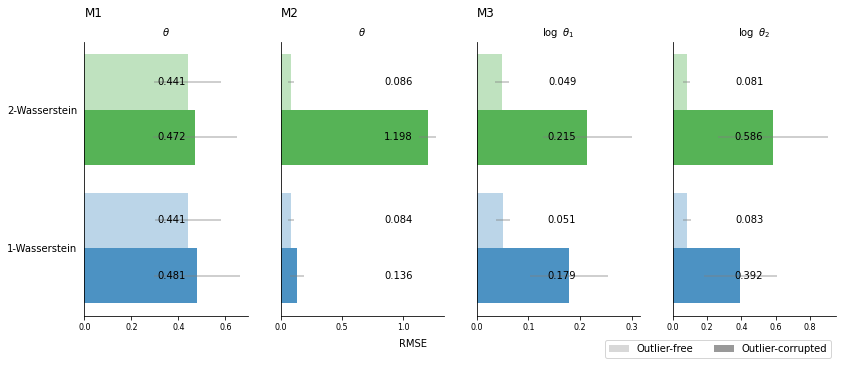

In [7]:
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import scipy.stats as stats
import pickle
import argparse

import slad
import pyabc

pyabc.settings.set_figure_params("pyabc")  # for beautified plots

data_dir = "../data_robust"

n_rep = 20

fontsize_big = 12
fontsize_medium = 10
fontsize_small = 8
padding = 0.3

distance_names = [
    "Wasserstein__2",
    "Wasserstein__1",
]

distance_labels_short = {
    "Wasserstein__2": "2-Wasserstein",
    "Wasserstein__1": "1-Wasserstein",
}

distance_colors = {
    "Wasserstein__2": "C2",
    "Wasserstein__1": "C0",
}

def create_vals(problem_type):
    if problem_type == "uninf":
        problem = slad.UninfErrorProblem()
    elif problem_type == "gaussian":
        problem = slad.GaussianErrorProblem()
    elif problem_type == "gk":
        problem = slad.PrangleGKErrorProblem()
    elif problem_type == "lv":
        problem = slad.PrangleLVErrorProblem()
    elif problem_type == "cr-zero":
        problem = slad.CRErrorZeroProblem()
    elif problem_type == "cr-swap":
        problem = slad.CRErrorSwapProblem()
    else:
        raise ValueError()

    gt_par = problem.get_gt_par()

    n_par = len(gt_par)
    n_dist = len(distance_names)

    vals = np.full(shape=(n_dist, 2, n_par, n_rep), fill_value=np.nan)

    for i_mode, kwargs in enumerate([{'n_obs_error': 0}, {}]):
        if problem_type == "uninf":
            problem = slad.UninfErrorProblem(**kwargs)
        elif problem_type == "gaussian":
            problem = slad.GaussianErrorProblem(**kwargs)
        elif problem_type == "gk":
            problem = slad.PrangleGKErrorProblem(**kwargs)
        elif problem_type == "lv":
            problem = slad.PrangleLVErrorProblem(**kwargs)
        elif problem_type == "cr-zero":
            problem = slad.CRErrorZeroProblem(**kwargs)
        elif problem_type == "cr-swap":
            problem = slad.CRErrorSwapProblem(**kwargs)

        for i_dist, distance_name in enumerate(distance_names):
            for i_rep in range(n_rep):
                h = pyabc.History(
                    f"sqlite:///{data_dir}/{problem.get_id()}_{i_rep}/db_{distance_name}.db",
                    create=False)

                df, w = h.get_distribution(t=h.max_t)
                vals[i_dist, i_mode, :, i_rep] = np.array(
                    [pyabc.weighted_rmse(df[key], w, gt_par[key])
                     for key in gt_par])

                # print(vals[i_dist, i_mode, :, i_rep])

    means = np.mean(vals, axis=3)
    stds = np.std(vals, axis=3)

    return means, stds, gt_par


def plot_rmse(
    problem_type,
    log: bool,
    axes,
    ylabels: bool,
):
    print(problem_type)
    means, stds, gt_par = create_vals(problem_type)
    n_par = len(gt_par)

    n_dist = len(distance_names)
    colors = list(distance_colors.values())
    for i_par, key in enumerate(gt_par.keys()):
        ax = axes[i_par]
        ys = np.arange(n_dist)
        if ylabels and i_par == 0:
            ax.set_yticks(np.arange(n_dist))
            ax.set_yticklabels([
                distance_labels_short[dname] for dname in distance_names],
                fontdict={"fontsize": fontsize_medium},
            )
            ax.yaxis.set_ticks_position("none")
        else:
            ax.set_yticks([])

        ax.invert_yaxis()
        ax.barh(
            ys - 0.2, means[:, 0, i_par],
            xerr=stds[:, 0, i_par],
            color=colors, alpha=0.3, height=0.4,
            error_kw={"ecolor": "grey", "alpha": 0.5},
        )
        ax.barh(
            ys + 0.2, means[:, 1, i_par],
            xerr=stds[:, 1, i_par],
            color=colors, alpha=0.8, height=0.4,
            error_kw={"ecolor": "grey", "alpha": 0.5},
        )
        if log:
            ax.set_xscale("log")

        # add value
        for i_dist in range(n_dist):
            for i in [0, 1]:
                max_val = means[:, :, i_par].max()
                if log:
                    pos_x = means[i_dist, i, i_par] * (1 + 1 / max_val)
                else:
                    pos_x = means[i_dist, i, i_par] + (1  + 1 / max_val)
                ax.text(max_val * 0.9,
                        i_dist - (-1)**i * 0.2,
                        f"{means[i_dist, i, i_par]:.3f}",
                        fontdict={"fontsize": fontsize_medium},
                        verticalalignment="center",
                        horizontalalignment="right")

        #ax.set_xlabel("RMSE")
        ax.set_title(slad.C.parameter_labels[problem_type][key], fontsize=fontsize_medium)
        #ax.axhline(y=3.5, color="grey", linestyle="dotted")

        plt.setp(ax.get_xticklabels(), fontsize=fontsize_small)
        plt.setp(ax.get_xminorticklabels(), visible=False)

    axes[0].text(
        0, 1.08, slad.C.problem_labels[problem_type],
        horizontalalignment="left", verticalalignment="bottom",
        transform=axes[0].transAxes, fontsize=fontsize_big,
    )

problem_types = [
    "uninf",
    "gaussian",
    "cr-zero",
    #"gk",
    #"lv",
]
arr_cols = [
    1,
    1,
    2,
    #4,
    #3,
]
fig, axes = plt.subplots(
    nrows=1, ncols=sum(arr_cols), figsize=(12, 5),
    # constrained_layout=True,
)

for i, (problem_type, cols) in enumerate(zip(problem_types, arr_cols)):
    axes_for_problem = axes[sum(arr_cols[:i]):sum(arr_cols[:i+1])]
    plot_rmse(
        problem_type=problem_type,
        log=False,
        axes=axes_for_problem,
        ylabels=i==0,
    )

# fig.tight_layout()
plt.subplots_adjust(left=0.12, right=0.99, top=0.89, bottom=0.13)

# x axis label
fig.text(
    0.5, 0.05, "RMSE",
    horizontalalignment="center", verticalalignment="center",
    fontsize=fontsize_medium,
)

# legend
legend_elements = [
    Patch(facecolor="grey", alpha=0.3, label="Outlier-free"),
    Patch(facecolor="grey", alpha=0.8, label="Outlier-corrupted"),
]
axes[-1].legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1, -0.07), ncol=2)
#plt.subplots_adjust(bottom=0.1)

for fmt in ["pdf", "png"]:
    plt.savefig(f"figure_rmse_wasserstein.{fmt}", format=fmt, dpi=200)
